In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")

In [3]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 621


In [4]:
# from datetime import datetime

# dts = [datetime.fromtimestamp(int(x)) for x in folders]
# print(max(dts))
# print(min(dts))

In [5]:
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

print(len(paths))

620


In [6]:
import torch

baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result

{'best_epoch': 229,
 'best_train_acc': 0.9999333333333333,
 'best_valid_acc': 0.9216,
 'best_valid_loss': 0.005079200401902199,
 'test_acc': 0.9137,
 'test_loss': 0.005285387974977494,
 'n_param': 11173962,
 'model_name': 'rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue'}

In [7]:
from tddl.post_processing.factorized_model import process_factorized_networks

# process_factorized_networks(paths, baseline_path)

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [8]:
from tddl.post_processing.path_utils import paths_to_df

df = paths_to_df(paths)
print(len(df))
df.head()


620


,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,test_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
0,conv2,63,0.311843,0.000023,54.784103,63,cp,0.1,0.9210,0.9216,0.9138,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964
1,conv1,60,0.337100,0.000027,62.611729,60,tucker,0.1,0.9206,0.9216,0.9138,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104
2,conv1,60,0.272814,0.000021,50.671532,60,tucker,0.25,0.9210,0.9216,0.9138,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201
3,conv1,60,0.152464,0.000012,28.318068,60,tt,80.0,0.9210,0.9216,0.9137,10954826,0.9147,0.00001,adam,17.516994,2603.942812,2048.0,0.006766,0.008553
4,conv1,28,0.823151,0.000408,60.229858,28,tucker,0.1,0.9018,0.8690,0.8610,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374


In [9]:
df['actual_rank'] = df['rank']
rank_conf = {
    10: [
        0.16,
        0.31,
        0.18,
        0.19,
        0.45,
        0.19,
        0.19,
        0.19,
    ],
    25: [
        0.61,
        1.43,
        1.22,
        2.39,
        1.21,
        2.39,
        4.78,
        4.78,
    ],
    50: [
        2.30,
        3.52,
        4.57,
        8.98,
        2.40,
        8.98,
        17.90,
        17.90,
    ],
    75: [
        6.60,
        7.8,
        12.97,
        25.6,
        28.0,
        25.6,
        50.0,
        50.0,
    ],
    90: [
        10.3,
        12.5,
        20.0,
        40.0,
        45.0,
        40.0,
        80.0,
        80.0,
    ],
}
for k,v in rank_conf.items():
    print(k,v)
    df.loc[df['rank'].isin(v), 'actual_rank'] = k/100

10 [0.16, 0.31, 0.18, 0.19, 0.45, 0.19, 0.19, 0.19]
25 [0.61, 1.43, 1.22, 2.39, 1.21, 2.39, 4.78, 4.78]
50 [2.3, 3.52, 4.57, 8.98, 2.4, 8.98, 17.9, 17.9]
75 [6.6, 7.8, 12.97, 25.6, 28.0, 25.6, 50.0, 50.0]
90 [10.3, 12.5, 20.0, 40.0, 45.0, 40.0, 80.0, 80.0]


In [10]:
# df.groupby('rank').count()
# rank=0.90: 10 observations
# rank=0.75: 10 observstions

# Exclude the few observations (layer=28, decomp={cp,tucker}) where rank is 0.75 or 0.90

df = df[~df['actual_rank'].isin([0.75, 0.90])]

In [11]:
df['test_error_before_ft'] = 1 - df.test_acc_before_ft
df['test_error'] = 1 - df.test_acc
df['valid_error_before_ft'] = 1 - df.valid_acc_before_ft
df['valid_error'] = 1 - df.valid_acc

df['log_test_error_before_ft'] = np.log(df.test_error_before_ft)
df['log_test_error'] = np.log(df.test_error)
df['log_valid_error_before_ft'] = np.log(df.valid_error_before_ft)
df['log_valid_error'] = np.log(df.valid_error)

In [12]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layers_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df.head()

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,test_error,valid_error_before_ft,valid_error,log_test_error_before_ft,log_test_error,log_valid_error_before_ft,log_valid_error,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,0.000023,54.784103,63,cp,0.10,0.9210,0.9216,...,0.0857,0.0784,0.0790,-2.451085,-2.456902,-2.545931,-2.538307,cp-0.1,cp-63,63-cp
1,conv1,60,0.337100,0.000027,62.611729,60,tucker,0.10,0.9206,0.9216,...,0.0863,0.0784,0.0794,-2.451085,-2.449926,-2.545931,-2.533257,tucker-0.1,tucker-60,60-tucker
2,conv1,60,0.272814,0.000021,50.671532,60,tucker,0.25,0.9210,0.9216,...,0.0852,0.0784,0.0790,-2.451085,-2.462754,-2.545931,-2.538307,tucker-0.25,tucker-60,60-tucker
4,conv1,28,0.823151,0.000408,60.229858,28,tucker,0.10,0.9018,0.8690,...,0.1026,0.1310,0.0982,-1.973281,-2.276917,-2.032558,-2.320749,tucker-0.1,tucker-28,28-tucker
5,conv1,28,0.305965,0.000152,22.387421,28,tucker,0.90,0.9182,0.9156,...,0.0855,0.0844,0.0818,-2.458070,-2.459239,-2.472188,-2.503478,tucker-0.9,tucker-28,28-tucker


In [13]:
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layers_fact':"category",
})

## Approximation error on the weights

In [14]:
df_rank = df.set_index('rank', inplace=False)

In [15]:
grouped_df = df_rank.groupby('factorization')
ax = grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error on weights', xlabel='relative rank')

KeyError: 'Column not found: error'

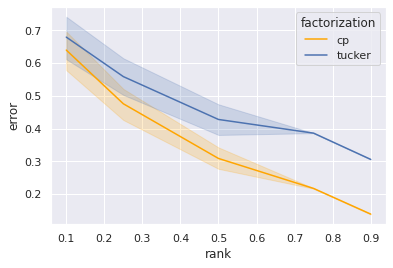

In [ ]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

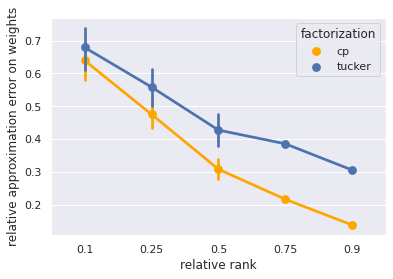

In [17]:
ax = sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.set(xlabel='relative rank', ylabel='relative approximation error on weights')

[(0.865, 0.925)]

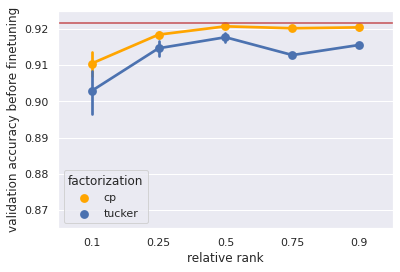

In [18]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative rank', ylabel='validation accuracy before finetuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

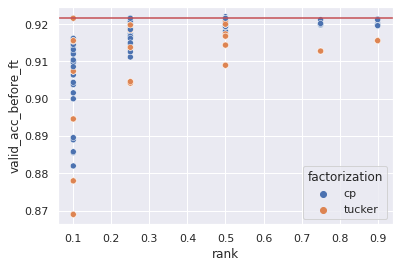

In [19]:
ax = sns.scatterplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

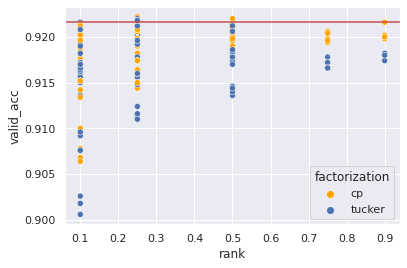

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

[(0.865, 0.925)]

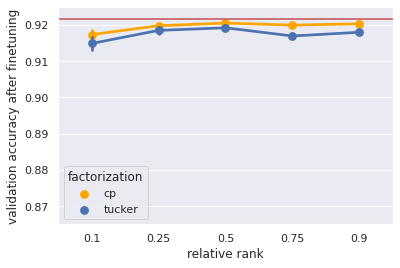

In [21]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='validation accuracy after finetuning')
ax.set(ylim=(0.865, 0.925))

[Text(0.5, 0, 'relative rank'), Text(0, 0.5, 'test accuracy after finetuning')]

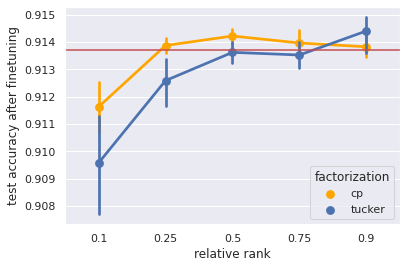

In [22]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='test accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

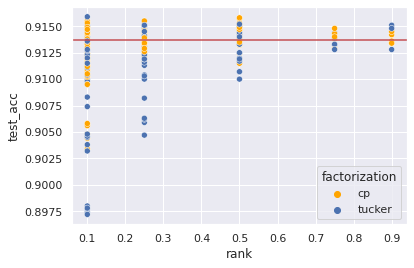

In [23]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['test_acc'], color='r')

In [24]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

[(0.865, 0.925)]

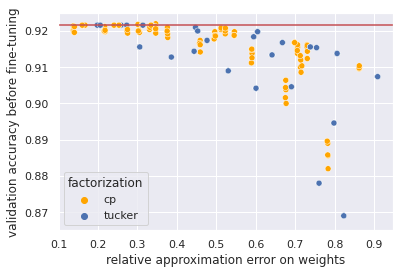

In [26]:
ax = sns.scatterplot(
    x="error", y="valid_acc_before_ft", 
    hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

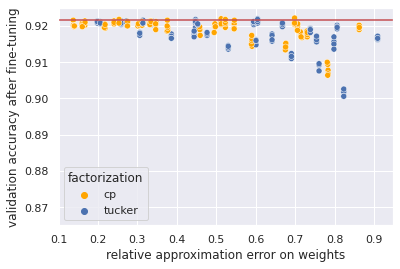

In [27]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

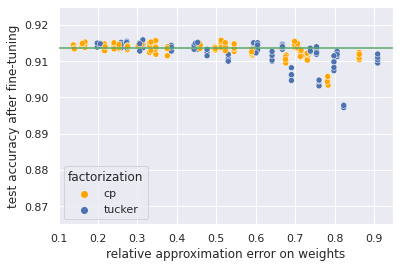

In [28]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

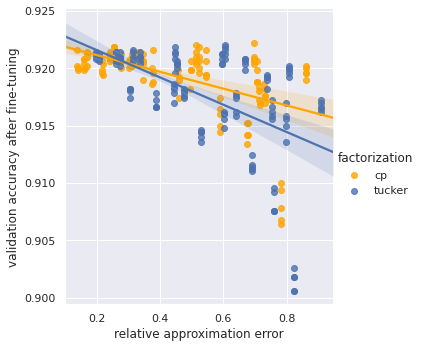

In [29]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')


In [30]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker


In [31]:
# g = sns.lmplot(x="error", y="test_acc", 
#    hue="fact_rank", 
#    data=df,
#    truncate=False, 
#    # palette=['orange','b'],
# )
# g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g.set(ylim=(0.935, 0.945))

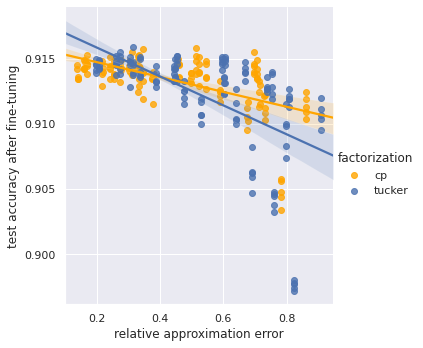

In [32]:
ax = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
ax.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')


In [33]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

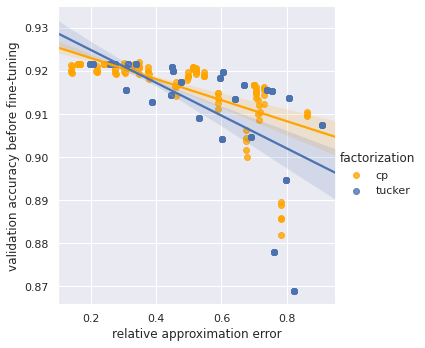

In [34]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [35]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
5,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam,6.153332,429.339663,2048.0,0.014415,0.003005
9,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam,47.736296,545.957711,16384.0,0.087451,0.002914
12,conv2,38,0.346829,38,cp,0.5,0.9212,0.9208,10879449,0.9119,0.00001,adam,54.038538,420.262521,4096.0,0.128686,0.013193
22,conv2,15,0.301261,15,cp,0.5,0.9200,0.9218,11155728,0.9141,0.00001,adam,47.295244,545.957711,16384.0,0.086648,0.002887
26,conv1,28,0.375088,28,cp,0.5,0.9186,0.9198,11100409,0.9134,0.00001,adam,110.821921,815.280181,8192.0,0.135994,0.013528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,conv2,63,0.160493,63,cp,0.5,0.9200,0.9216,9995161,0.9147,0.00001,adam,4.984808,429.339663,2048.0,0.011677,0.002434
251,conv1,60,0.167152,60,cp,0.5,0.9210,0.9216,9995161,0.9153,0.00001,adam,20.135873,2603.942812,2048.0,0.007780,0.009832
255,conv1,44,0.447319,44,tucker,0.5,0.9212,0.9210,10879741,0.9150,0.00001,adam,135.603151,726.060440,4096.0,0.186951,0.033106
256,conv2,63,0.160246,63,cp,0.5,0.9198,0.9216,9995161,0.9149,0.00001,adam,4.885679,429.339663,2048.0,0.011455,0.002386


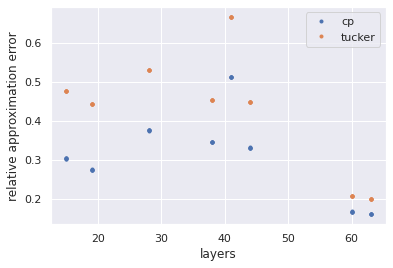

In [36]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [37]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [38]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

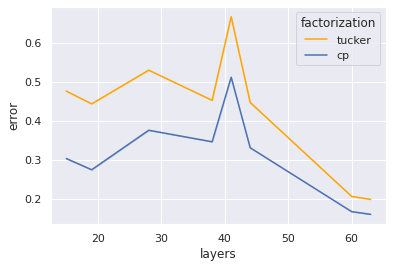

In [39]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
ax = sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

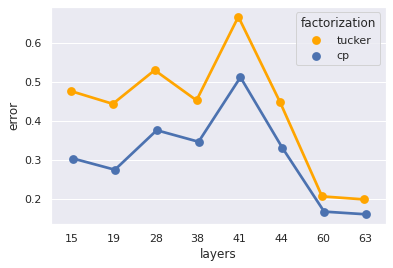

In [40]:
ax = sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

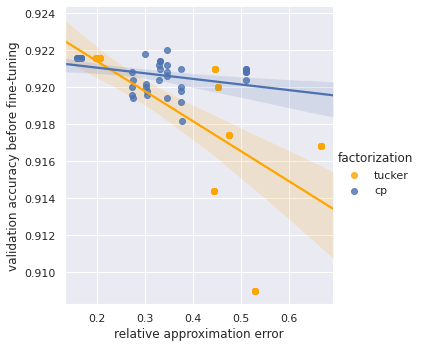

In [41]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

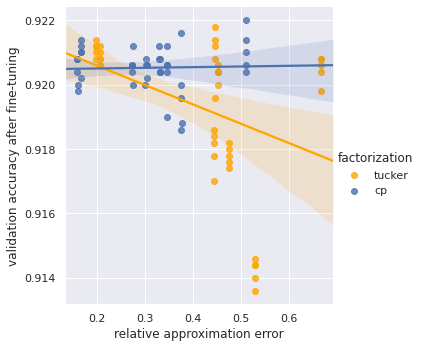

In [42]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

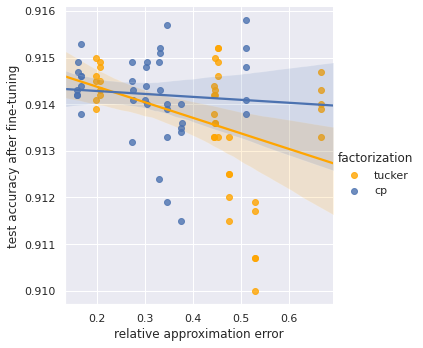

In [43]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

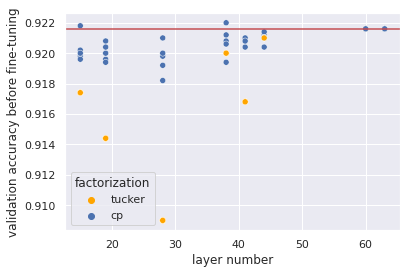

In [44]:
ax = sns.scatterplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    # dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

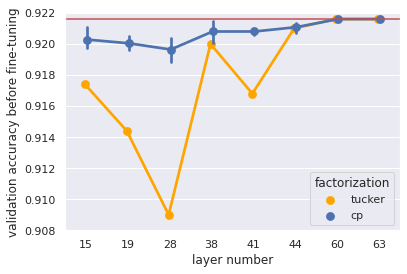

In [45]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

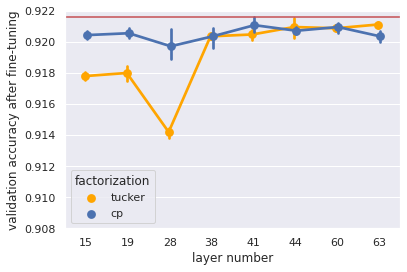

In [46]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')
ax.set(ylim=(0.908, 0.9220))


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

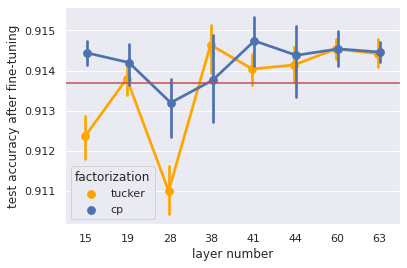

In [47]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [48]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
255    False
256    False
257    False
258    False
259    False
Name: factorization, Length: 260, dtype: bool

In [49]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact


In [50]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.10 &   0.000687 &  0.000886 \\
       &    & 0.25 &   0.000876 &  0.000358 \\
       &    & 0.50 &   0.000329 &  0.000404 \\
       &    & 0.75 &        NaN &       NaN \\
       &    & 0.90 &        NaN &       NaN \\
       & 19 & 0.10 &   0.000767 &  0.000858 \\
       &    & 0.25 &   0.000890 &  0.000658 \\
       &    & 0.50 &   0.000434 &  0.000632 \\
       &    & 0.75 &        NaN &       NaN \\
       &    & 0.90 &        NaN &       NaN \\
       & 28 & 0.10 &   0.001579 &  0.000970 \\
       &    & 0.25 &   0.001178 &  0.000597 \\
       &    & 0.50 &   0.001197 &  0.000977 \\
       &    & 0.75 &   0.000518 &  0.000702 \\
       &    & 0.90 &   0.000729 &  0.000502 \\
       & 38 & 0.10 &   0.000616 &  0.000823 \\
       &    & 0.25 &   0.001033 &  0.000862 \\
       &    & 0.50 &   0.000817 &  0.001370 \\
       &  

## Analysis on the features space

### Relative Norm

[(0.865, 0.925)]

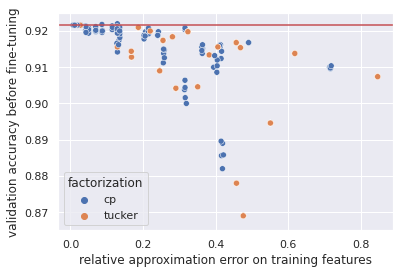

In [51]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

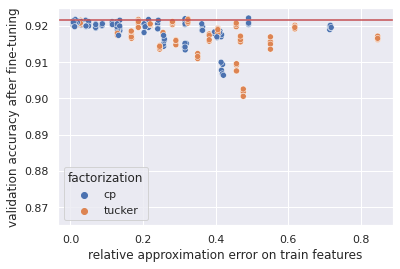

In [52]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

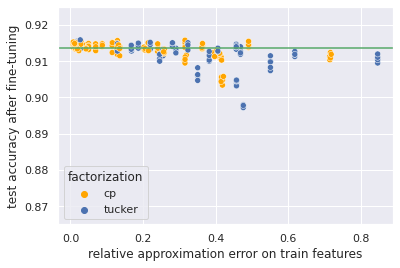

In [53]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

### Scaled Norm

[(0.865, 0.925)]

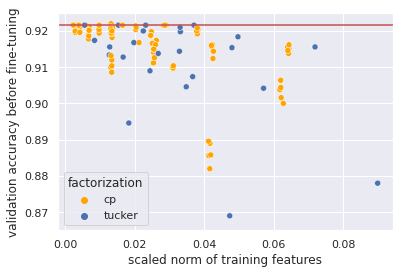

In [54]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

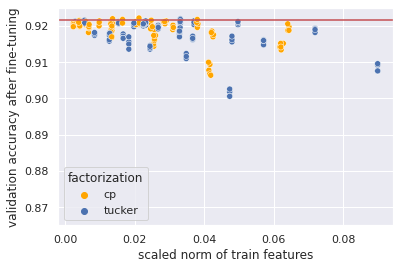

In [55]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

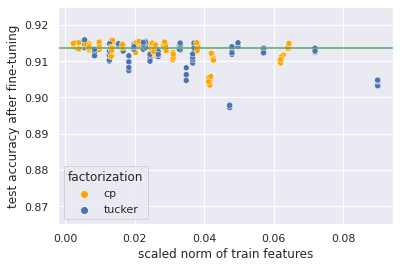

In [56]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

### Absolute Norm

[(0.865, 0.925)]

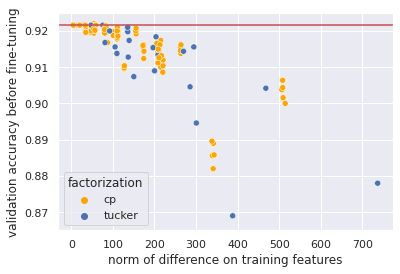

In [57]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='Absolute norm on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

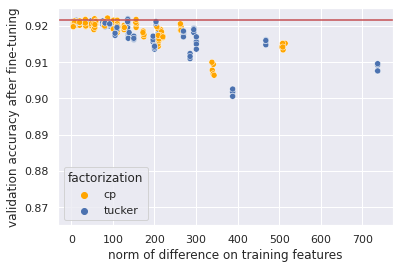

In [58]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute norm on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

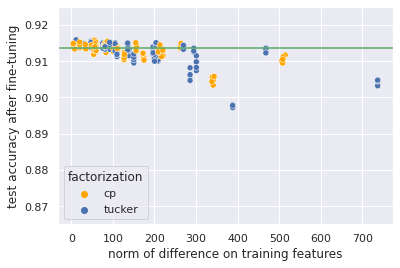

In [59]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='Absolute norm on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

In [60]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

[(0.865, 0.925)]

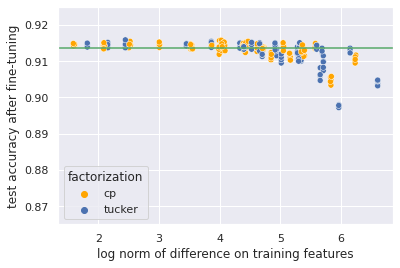

In [61]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(
    xlabel='Log absolute norm on training features', 
    ylabel='Test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

In [62]:
df['log_test_acc'] = np.log(df.test_acc)

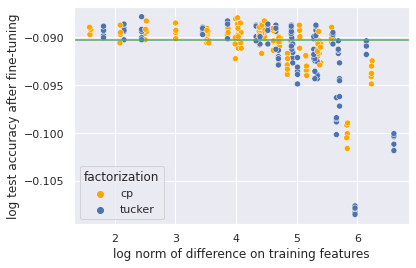

In [63]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(
    xlabel='Log Absolute norm on training features', 
    ylabel='Log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))

# Per Layer

In [14]:
df.columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'test_acc_before_ft', 'n_param_fact', 'test_acc',
       'lr', 'optimizer', 'norm_diff', 'norm_b', 'n_b', 'relative_norm',
       'scaled_norm', 'actual_rank', 'test_error_before_ft', 'test_error',
       'valid_error_before_ft', 'valid_error', 'log_test_error_before_ft',
       'log_test_error', 'log_valid_error_before_ft', 'log_valid_error',
       'fact_rank', 'fact_layers', 'layers_fact'],
      dtype='object')

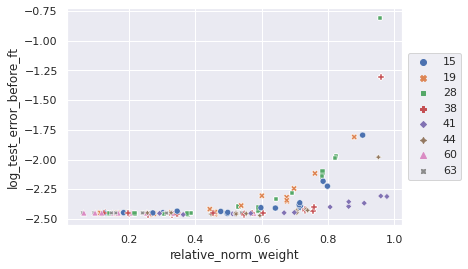

In [15]:
ax = sns.scatterplot(x="relative_norm_weight", y="log_test_error_before_ft",
    hue="layers",
    style="layers",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
# ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
# ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

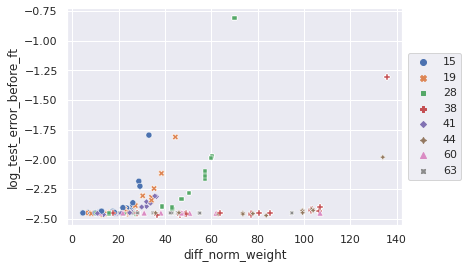

In [16]:
ax = sns.scatterplot(x="diff_norm_weight", y="log_test_error_before_ft",
    hue="layers",
    style="layers",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
# ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
# ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

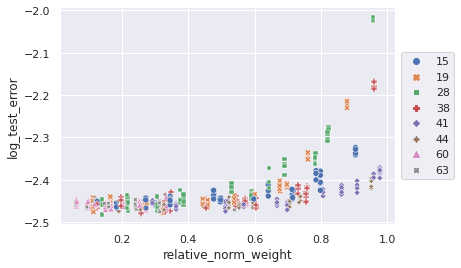

In [17]:
ax = sns.scatterplot(x="relative_norm_weight", y="log_test_error",
    hue="layers",
    style="layers",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
# ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
# ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

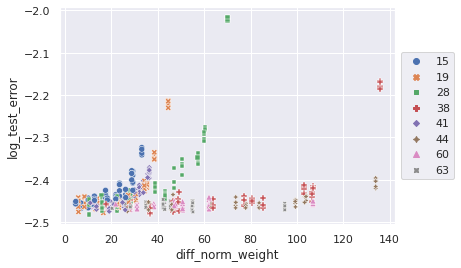

In [18]:
ax = sns.scatterplot(x="diff_norm_weight", y="log_test_error",
    hue="layers",
    style="layers",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
# ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
# ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7fa354cae100> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


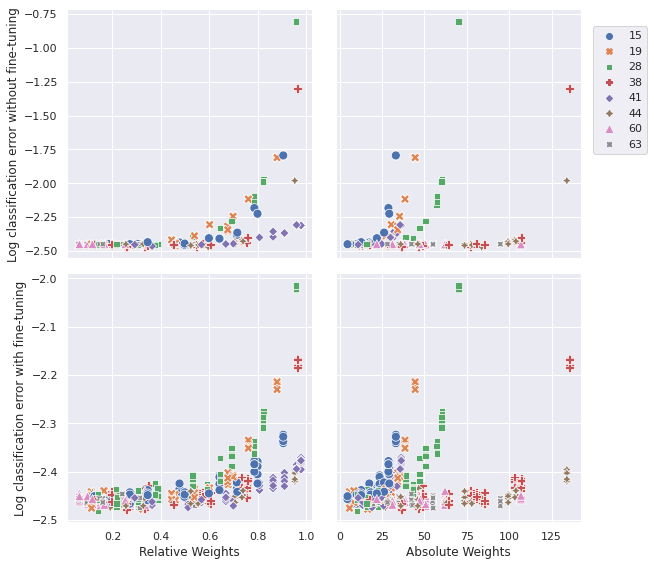

In [19]:
from matplotlib import pyplot as plt 

replacements = {
    # 'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    # 'valid_acc': "Validation accuracy after fine-tuning",
    # 'test_acc': "Test accuracy after fine-tuning", 
    # 'error': 'Relative norm on weights',
    # 'relative_norm': 'Relative norm on training features',
    # 'scaled_norm': 'Scaled norm on training features',
    # 'norm_diff': 'Absolute norm on training features',
    # 'log_norm_diff': 'Log absolute norm on training features',
    'log_test_error_before_ft': "Log classification error without fine-tuning",
    'log_test_error':"Log classification error with fine-tuning",
    'relative_norm_weight': "Relative Weights",
    'diff_norm_weight': "Absolute Weights",
}

metrics=['test_error_before_ft','test_error']
log_metrics=['log_test_error_before_ft','log_test_error']
errors=['relative_norm_weight','diff_norm_weight'] # 'relative_norm','scaled_norm_weight','scaled_norm',,'norm_diff'

g = sns.PairGrid(
    df,
    y_vars=log_metrics, 
    x_vars=errors, # "error"
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.layers,legend='auto',s=80)) # color=".3")
# g.set(ylim=(0.86,0.925))
g.add_legend()

def error(accuracy):
    return 1-accuracy

def log_error(accuracy):
    return np.log(1-accuracy)

lines = {
    0: {
        "y":error(baseline_result['best_valid_acc']),
        "color":'black',
    },
    1: {
        "y":error(baseline_result['best_valid_acc']),
        "color":'black',
    },
    2: {
        "y":error(baseline_result['test_acc']),
        "color":'black',
    },
}

for i in range(2):
    for j in range(2):
        gax = g.axes[i][j]
#         gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

g.savefig("../../plots/rn18_scatter_relative_absolute")

## Feature Space

### Relative Norm

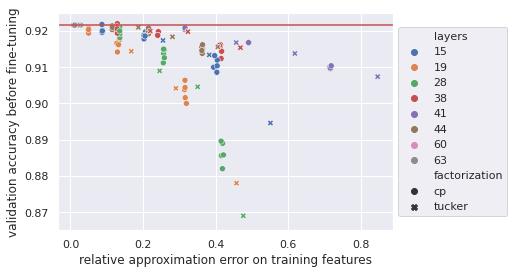

In [15]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

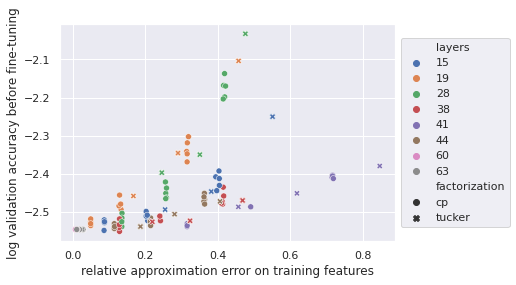

In [16]:
ax = sns.scatterplot(
    x="relative_norm", y="log_valid_error_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='log validation accuracy before fine-tuning'
)
# ax.axhline(baseline_result['best_valid_acc'], color='r')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

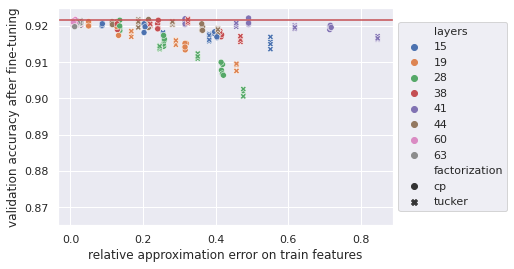

In [17]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

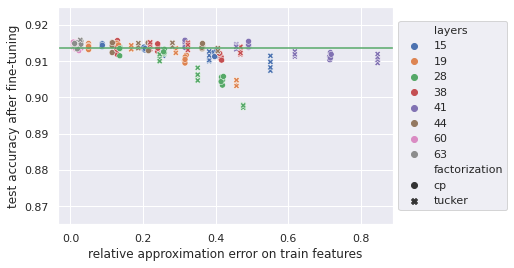

In [18]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Scaled Norm

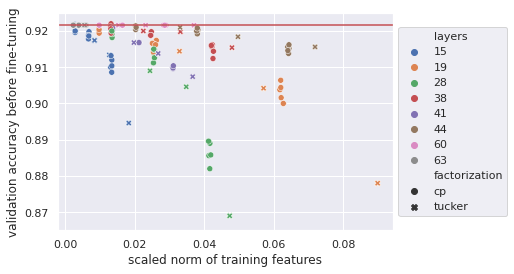

In [19]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

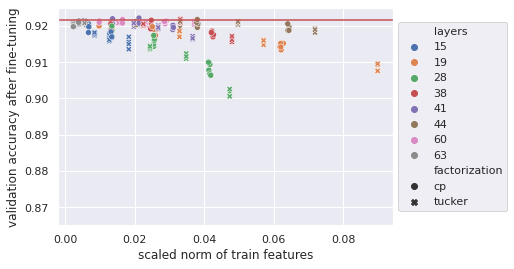

In [20]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

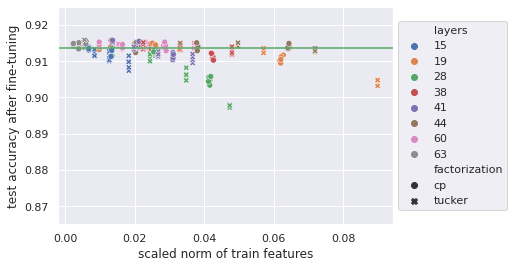

In [21]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Absolute Norm

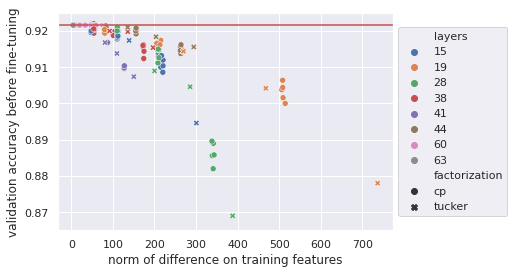

In [22]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='Absolute norm on training features', 
    ylabel='Validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

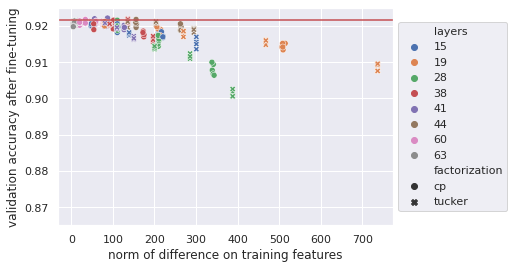

In [23]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute norm on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

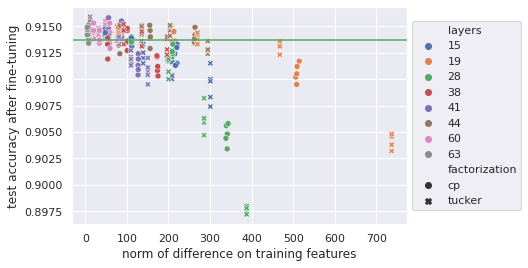

In [24]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute norm on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [25]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

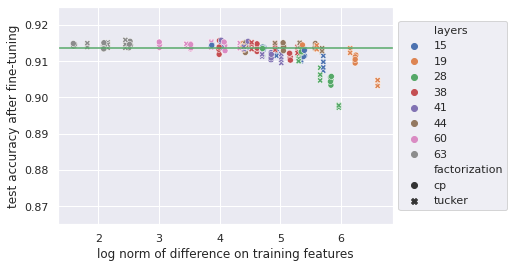

In [26]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Absolute log norm on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
df['log_test_acc'] = np.log(df.test_acc)

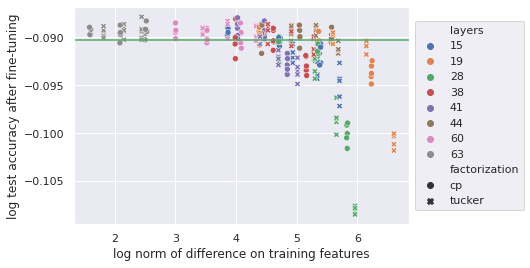

In [28]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='Log Absolute norm on training features', ylabel='Log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

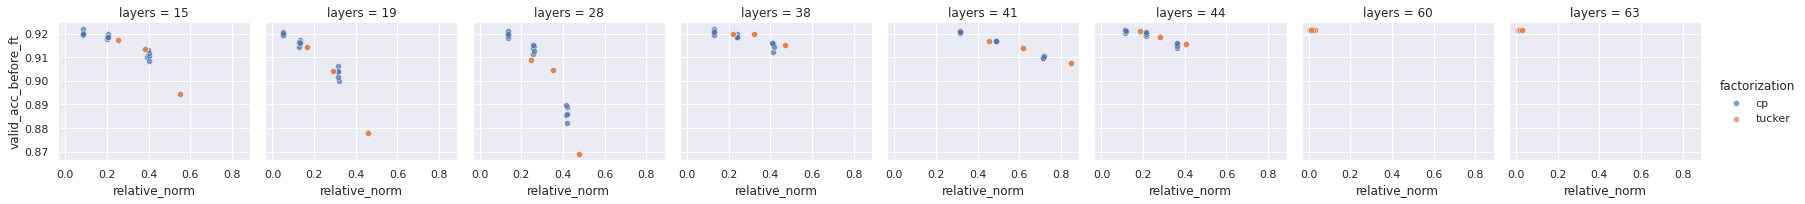

In [29]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc_before_ft", alpha=.7)
g.add_legend()

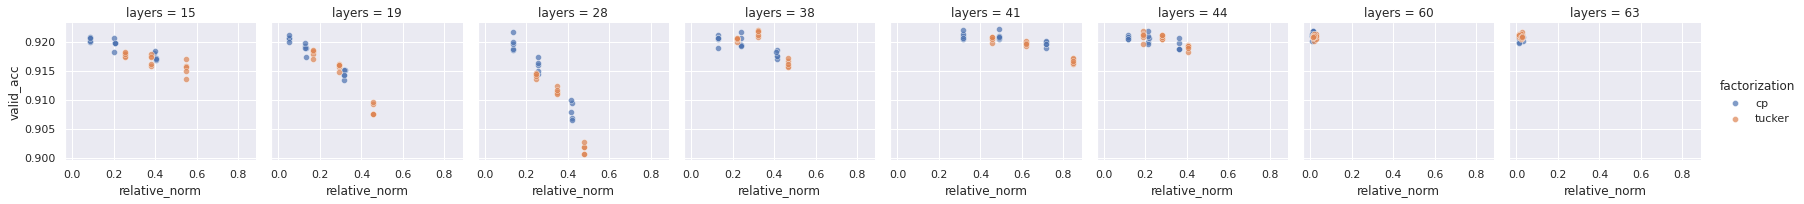

In [30]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc", alpha=.7)
g.add_legend()

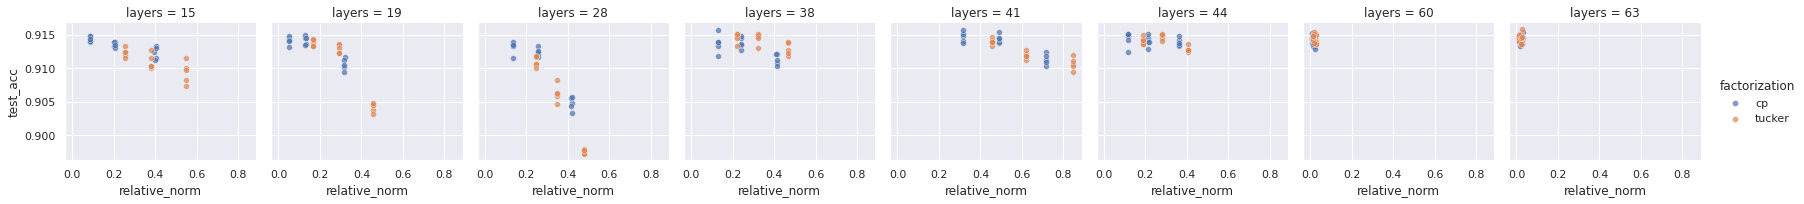

In [31]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "test_acc", alpha=.7)
g.add_legend()
# g.axhline(np.log(baseline_result['test_acc']), color='g')

In [108]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'error': 'Relative norm on weights',
    'relative_norm': 'Relative norm on training features',
    'scaled_norm': 'Scaled norm on training features',
    'norm_diff': 'Absolute norm on training features',
    'log_norm_diff': 'Log absolute norm on training features',
}

KeyError: "['error'] not in index"

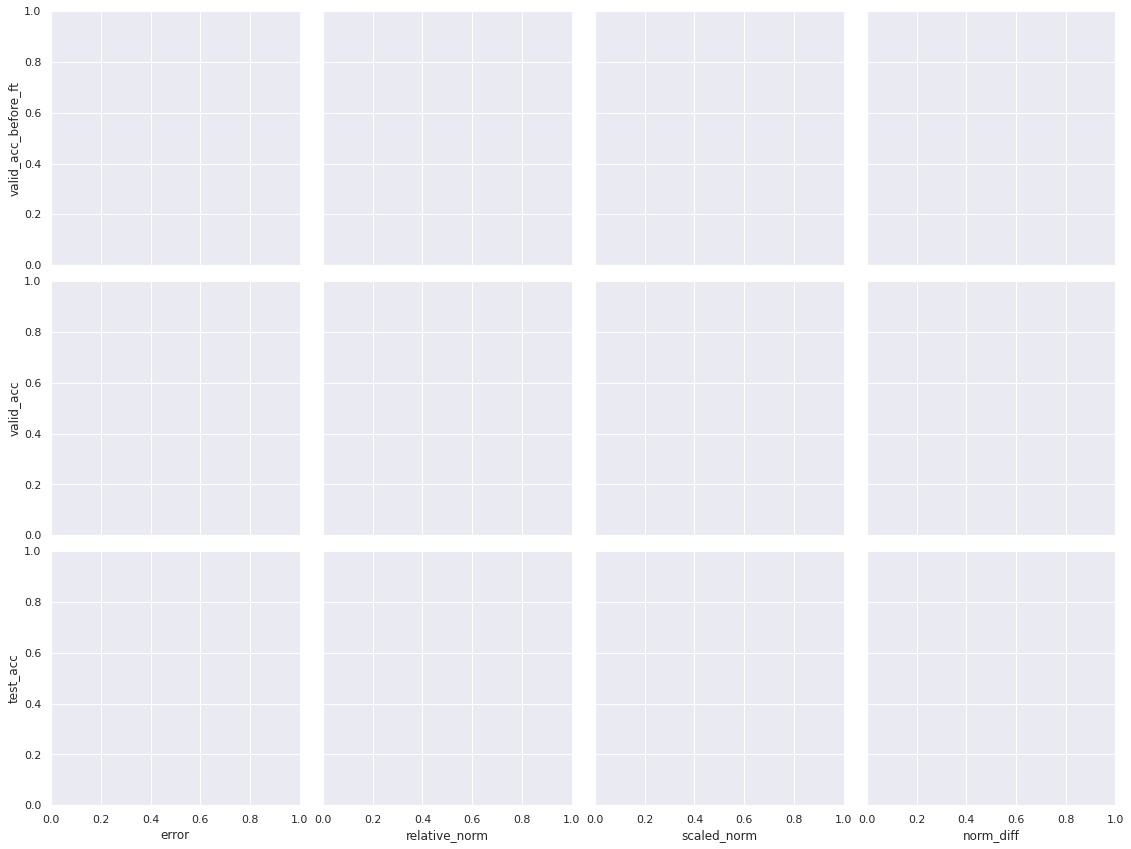

In [109]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])



In [110]:
df.relative_norm

0      0.028521
1      0.029340
2      0.018346
3      0.476089
5      0.014415
         ...   
255    0.186951
256    0.011455
257    0.219677
258    0.550880
259    0.406067
Name: relative_norm, Length: 240, dtype: float64

In [48]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'relative_norm_weight': 'Relative Weights',
    'scaled_norm_weight': 'Scaled Weights',
    'diff_norm_weight': 'Absolute Weights',
    'relative_norm': 'Relative Features',
    'scaled_norm': 'Scaled Features',
    'norm_diff': 'Absolute Features',
    'log_valid_error_before_ft': 'Log Validation error before fine-tuning',
    'log_valid_error': 'Log Validation error after fine-tuning',
    'log_test_error': 'Log Test error after fine-tuning',
    'valid_error_before_ft': 'Validation error before fine-tuning',
    'valid_error': 'Validation error after fine-tuning',
    'test_error': 'Test error after fine-tuning'
    # 'log_norm_diff': 'Log absolute norm between training features',
}

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7ff4b74e7eb0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


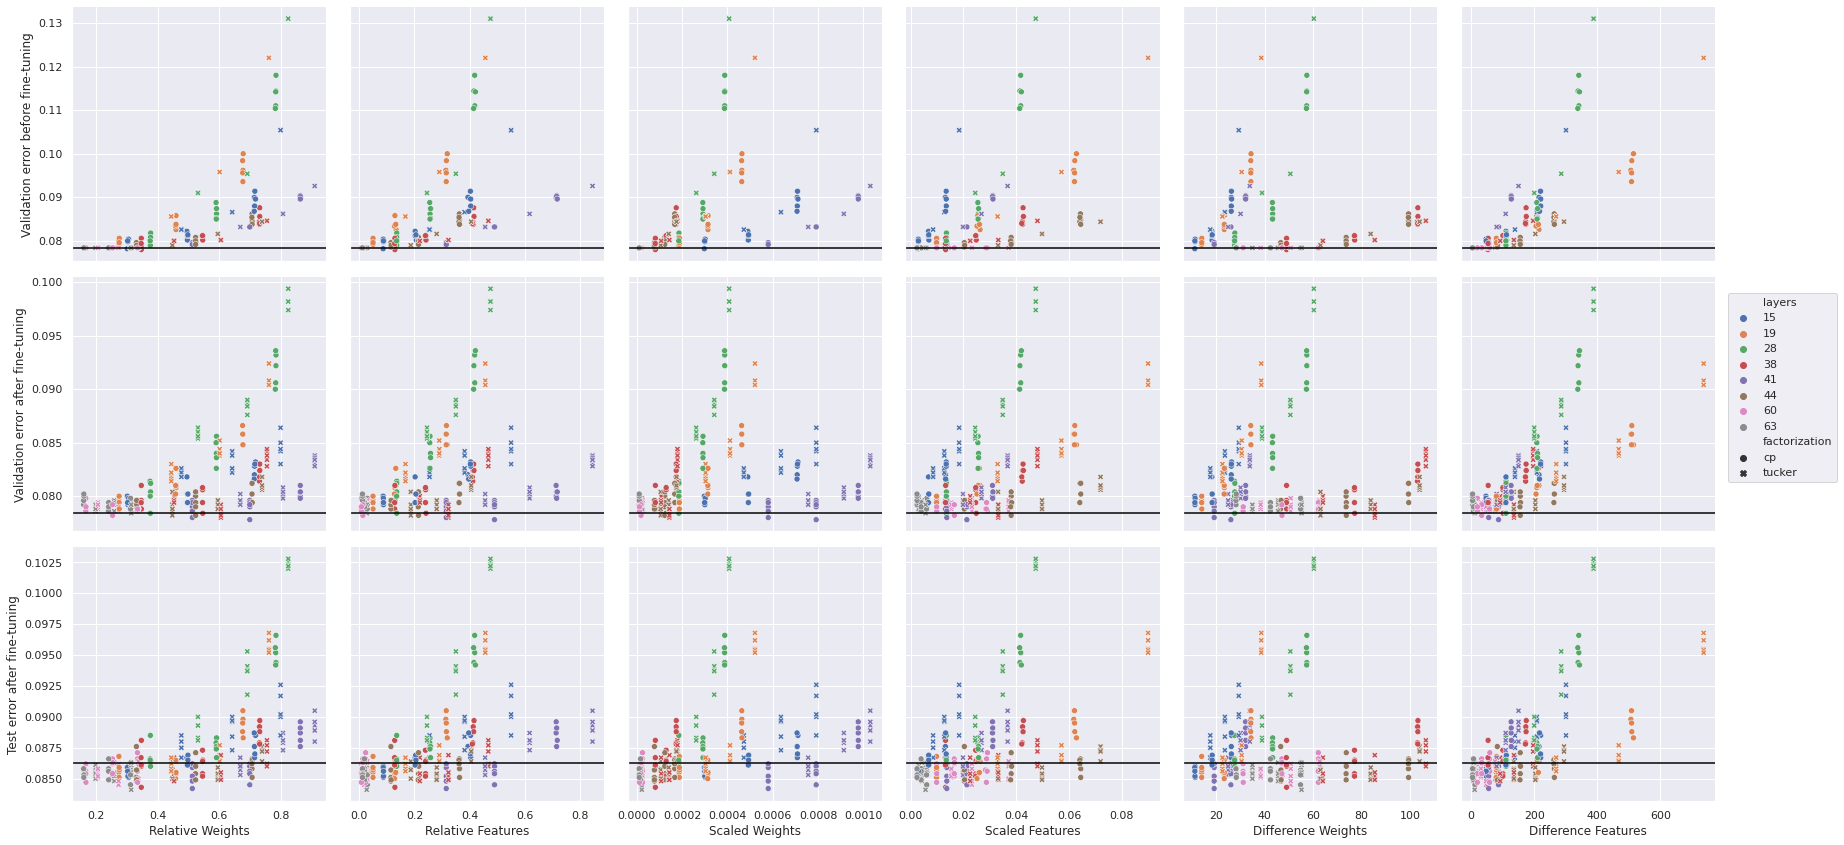

In [49]:
from matplotlib import pyplot as plt 

metrics=['valid_error_before_ft','valid_error','test_error']
log_metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

g = sns.PairGrid(
    df,
    y_vars=metrics, 
    x_vars=errors, # "error"
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
# g.set(ylim=(0.86,0.925))
g.add_legend()

def error(accuracy):
    return 1-accuracy

def log_error(accuracy):
    return np.log(1-accuracy)

lines = {
    0: {
        "y":error(baseline_result['best_valid_acc']),
        "color":'black',
    },
    1: {
        "y":error(baseline_result['best_valid_acc']),
        "color":'black',
    },
    2: {
        "y":error(baseline_result['test_acc']),
        "color":'black',
    },
}

for i in range(3):
    for j in range(6):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

g.savefig("../../plots/cifar10/rn18/scatter_errors_performances_layers_factorizations")

KeyError: 'error'

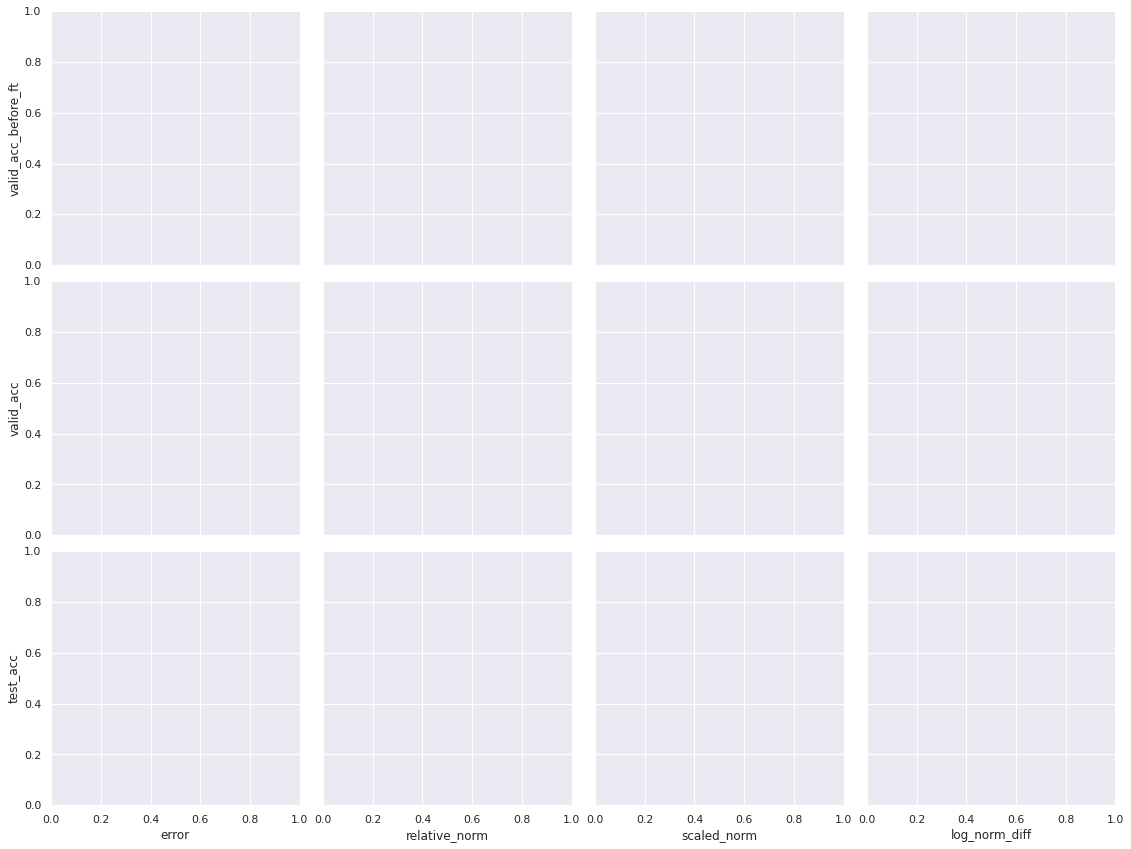

In [37]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"log_norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=(0.86,0.925))
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

# g.savefig("../../plots/cifar10/rn18/scatter_errors_performances_layers_factorizations")

In [38]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


KeyError: "['error'] not in index"

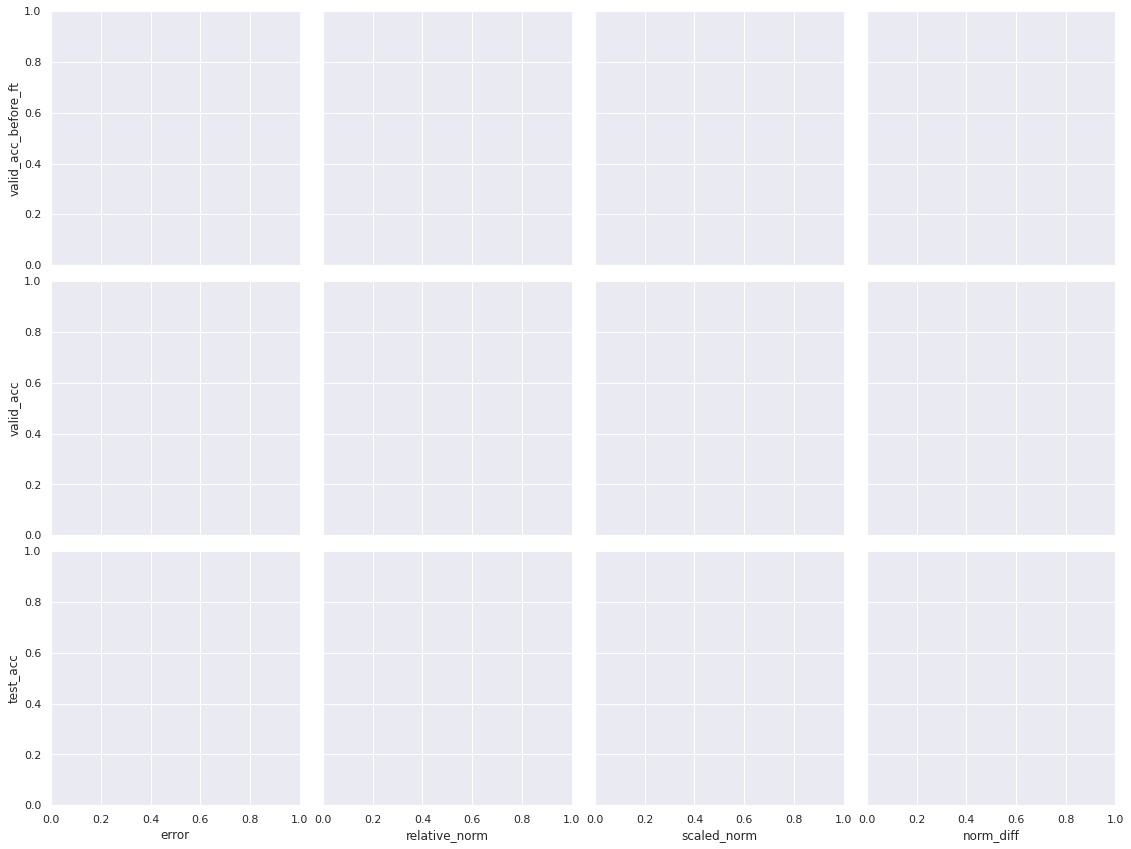

In [39]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="factorization",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

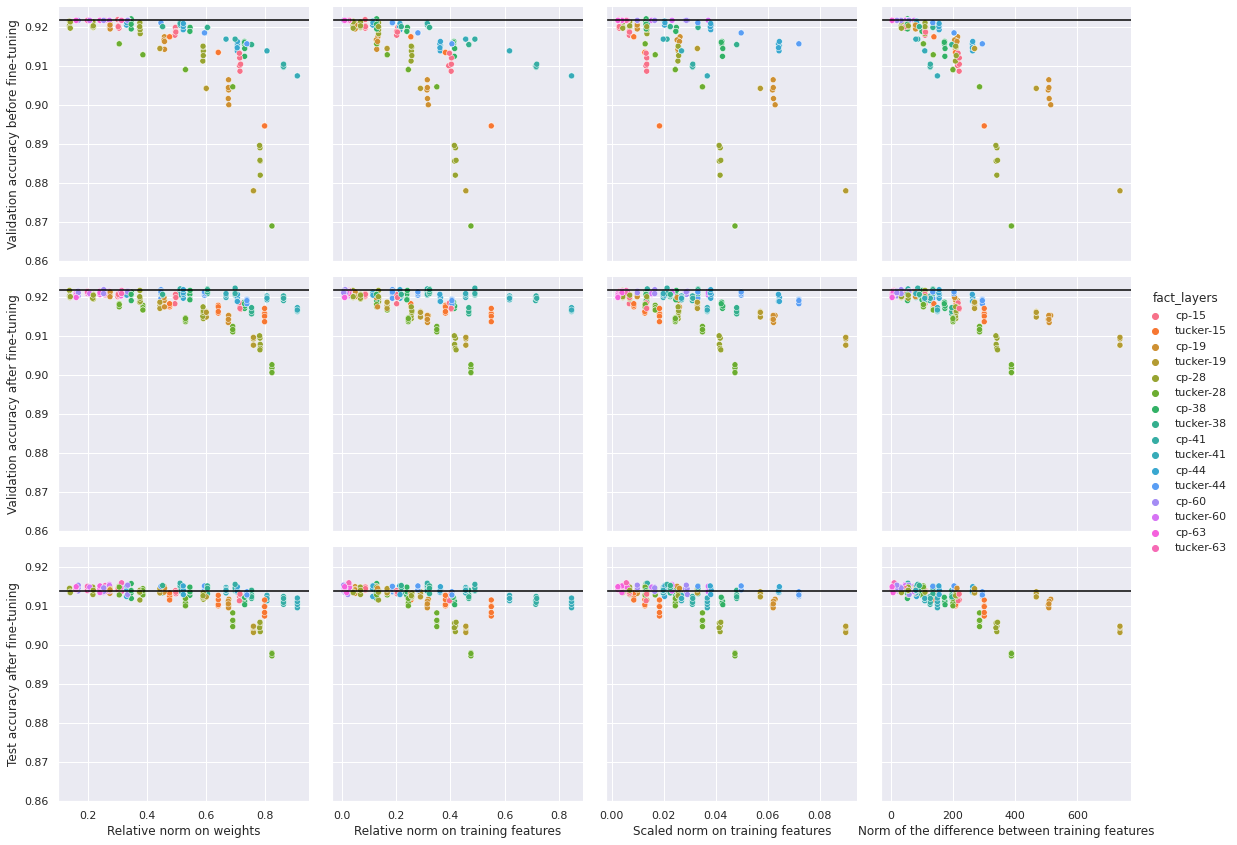

In [89]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="fact_layers",
    height=4,
    hue_order=[
        'cp-15','tucker-15','cp-19','tucker-19','cp-28','tucker-28','cp-38','tucker-38',
        'cp-41','tucker-41','cp-44','tucker-44','cp-60','tucker-60','cp-63','tucker-63',
    ]
    # palette=['b','orange']
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

In [90]:
df

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,...,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact,log_norm_diff,log_test_acc
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,...,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp,2.502660,-0.089597
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,...,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker,4.330593,-0.090253
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,...,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker,3.861071,-0.089050
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,...,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker,5.961226,-0.108254
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,...,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker,4.657420,-0.089378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,conv1,44,0.447319,44,tucker,0.50,0.9212,0.9210,10879741,0.9150,...,135.603151,726.060440,4096.0,0.186951,0.033106,tucker-0.5,tucker-44,44-tucker,4.909733,-0.088831
256,conv2,63,0.160246,63,cp,0.50,0.9198,0.9216,9995161,0.9149,...,4.885679,429.339663,2048.0,0.011455,0.002386,cp-0.5,cp-63,63-cp,1.586308,-0.088941
257,conv2,38,0.452808,38,tucker,0.50,0.9206,0.9200,10879741,0.9152,...,92.270423,420.262521,4096.0,0.219677,0.022527,tucker-0.5,tucker-38,38-tucker,4.524724,-0.088613
258,conv2,15,0.798234,15,tucker,0.10,0.9170,0.8946,11140672,0.9115,...,300.793008,545.957711,16384.0,0.550880,0.018359,tucker-0.1,tucker-15,15-tucker,5.706422,-0.092664


# Kendals tau

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

In [16]:
def p_to_asterisks(p):
    """
    Estimates are significantly different from zero at 1\% significance level, 
    unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), 
    or not significantly different from zero (***).
    """
    if p < 0.01:
        asterisk = ""
    elif p < 0.05:
        asterisk = "*"
    elif p < 0.1:
        asterisk = "**"
    else:
        asterisk = "***"
    return asterisk

In [17]:
from scipy.stats.mstats_basic import kendalltau
from functools import partial

kendalltau_a = partial(kendalltau, use_ties=False, use_missing=False, method='auto')
# kendalltau(x, y, use_ties=True, use_missing=False, method='auto')

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names


metrics=['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff','layers']
# errors = ['relative_norm_weight','scaled_norm_weight','diff_norm_weight', 'relative_norm','scaled_norm','norm_diff','layers']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_kt = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = kendalltau_a(df[error], df[metric])
        df_kt[error][metric] = "{:.2f}{}".format(corr,p_to_asterisks(p))


In [18]:

# df_kt.to_pickle("./tables/kt_rn18_c10_classification_error.zip")

In [19]:
# from scipy.stats import kendalltau

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names

# errors = ['error', 'relative_norm','scaled_norm','norm_diff']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

# columns = []
# for error in errors:
#     columns.append(f'{error}_tau')
#     columns.append(f'{error}_p')

# df_kt = pd.DataFrame(index=metrics, columns=errors)

# for error in errors:
#     for metric in metrics:
#         corr, p = kendalltau(df[error], df[metric])
#         df_kt[f'{error}_tau'][metric] = corr
#         df_kt[f'{error}_p'][metric] = p

In [20]:
# df_kt.to_pickle("./tables/kt_rn18_c10.zip")

In [21]:
neat_table_indices = {
    'test_acc_before_ft': "Val. before f.t.",
    'valid_acc_before_ft': "Val. before f.t.",
    'valid_acc': "Val. after f.t.",
    'test_acc': "Test after f.t.",
}
neat_table_columns = {
    'error': "Relative-weights",
    'relative_norm': "Relative-features",
    'scaled_norm': "Scaled-features",
    'norm_diff': "Absolute-features"}
df_kt.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)
df_kt

,relative_norm_weight,Relative-features,scaled_norm_weight,Scaled-features,diff_norm_weight,Absolute-features,layers
log_valid_error_before_ft,0.65,0.67,0.61,0.48,0.13,0.68,-0.44
log_valid_error,0.47,0.48,0.45,0.34,0.09,0.54,-0.37
log_test_error_before_ft,0.42,0.40,0.35,0.30,0.05**,0.42,-0.23
log_test_error,0.49,0.49,0.42,0.33,0.12,0.47,-0.29


In [22]:
print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='kt_rn18_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{kt_rn18_c10_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & Relative-features & scaled\_norm\_weight & Scaled-features & diff\_norm\_weight & Absolute-features & layers \\
\midrule
log\_valid\_error\_before\_ft &                 0.65 &              0.67 &               0.61 &            0.48 &             0.13 &              0.68 &  -0.44 \\
log\_valid\_error           &                 0.47 &              0.48 &               0.45 &            0.34 &     

In [23]:
df.layers.astype(str).unique()

array(['63', '60', '28', '38', '41', '44', '15', '19'], dtype=object)

In [24]:
errors_metrics = []

for error in errors:
    for metric in metrics:
        errors_metrics.append(f'{error}-{metric}')

layers = ['15','19','28','38','41','44','60','63']

df_kt_layers = pd.DataFrame(
    index=errors_metrics,
    columns=layers,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau_a(df_layer[error], df_layer[metric])
            df_kt_layers[str(layer)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))
    

In [25]:
neat_table_indices_layers = {
    'error-test_acc_before_ft': "Test before f.t.-weight",
    'error-valid_acc_before_ft': "Val. before f.t.-weight",
    'error-valid_acc': "Val. after f.t.-weight",
    'error-test_acc': "Test after f.t.-weight",

    'relative_norm-valid_acc_before_ft': "Val. before f.t.-rel. feat.",
    'relative_norm-valid_acc': "Val. after f.t.-rel. feat.",
    'relative_norm-test_acc': "Test after f.t.-rel. feat.",

    'scaled_norm-valid_acc_before_ft': "Val. before f.t.-sc. feat",
    'scaled_norm-valid_acc': "Val. after f.t.-sc. feat",
    'scaled_norm-test_acc': "Test after f.t.-sc. feat",

    'norm_diff-valid_acc_before_ft': "Val. before f.t.-diff. feat",
    'norm_diff-valid_acc': "Val. after f.t.-diff. feat",
    'norm_diff-test_acc': "Test after f.t.-diff. feat",
}

df_kt_layers.rename(index=neat_table_indices_layers, inplace=True)
df_kt_layers

,15,19,28,38,41,44,60,63
relative_norm_weight-log_valid_error_before_ft,0.79,0.83,0.78,0.77,0.86,0.81,0.00***,0.00***
relative_norm_weight-log_valid_error,0.71,0.78,0.85,0.51,0.60,0.51,0.04***,0.02***
relative_norm_weight-log_test_error_before_ft,0.72,0.82,0.82,0.55,0.75,0.16**,-0.50,-0.23
relative_norm_weight-log_test_error,0.67,0.68,0.83,0.54,0.66,0.36,0.12***,-0.08***
relative_norm-log_valid_error_before_ft,0.87,0.87,0.81,0.74,0.86,0.84,0.00***,0.00***
relative_norm-log_valid_error,0.75,0.82,0.87,0.51,0.60,0.51,0.01***,0.01***
relative_norm-log_test_error_before_ft,0.74,0.83,0.84,0.53,0.75,0.18*,-0.48,-0.19*
relative_norm-log_test_error,0.72,0.67,0.83,0.51,0.66,0.33,0.13***,-0.08***
scaled_norm_weight-log_valid_error_before_ft,0.79,0.83,0.78,0.77,0.86,0.81,0.00***,0.00***
scaled_norm_weight-log_valid_error,0.71,0.78,0.85,0.51,0.60,0.51,0.04***,0.01***


In [26]:
print(df_kt_layers.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='kt_rn18_c10_errors_performances_layers',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lllllllll}
\toprule
{} &       15 &       19 &       28 &       38 &       41 &       44 &       60 &        63 \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &     0.79 &     0.83 &     0.78 &     0.77 &     0.86 &     0.81 &  0.00*** & 

In [27]:
df.factorization.unique()

array(['cp', 'tucker', 'tt'], dtype=object)

In [28]:
factorizations = ['cp', 'tucker', 'tt']

df_kt_factorizations = pd.DataFrame(
    index=errors_metrics,
    columns=factorizations,
)

for fact in df.factorization.unique():
    df_ = df[df.factorization==fact]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau_a(df_[error], df_[metric])
            df_kt_factorizations[str(fact)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))

df_kt_factorizations.rename(index=neat_table_indices_layers, inplace=True)

print(df_kt_factorizations.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='kt_rn18_c10_errors_performances_factorization',
))
    

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{kt_rn18_c10_errors_performances_factorization}
\begin{tabular}{llll}
\toprule
{} &       cp &    tucker &       tt \\
\midrule
relative\_norm\_weight-log\_valid\_error\_before\_ft &     0.61 &      0.62 &     0.68 \\
relative\_norm\_weight-log\_valid\_error           &     0.37 &      0.47 &     0.54 \\

## Mean and std

In [29]:
metrics=['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

In [30]:
from tddl.post_processing.kendalls_tau import split_into_run, calculate_kendalls_tau_per_run, mean_std_over_runs

dfs = split_into_run(df, 5)
df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_kt_mean_std = mean_std_over_runs(df_kts, errors=errors, metrics=metrics)
df_kt_mean_std

,relative_norm_weight,relative_norm,scaled_norm_weight,scaled_norm,diff_norm_weight,norm_diff
log_valid_error_before_ft,0.66±0.01,0.68±0.01,0.62±0.02,0.48±0.01,0.13±0.02,0.69±0.00
log_valid_error,0.47±0.03,0.48±0.03,0.45±0.02,0.35±0.03,0.09±0.01,0.54±0.03
log_test_error_before_ft,0.42±0.02,0.40±0.01,0.35±0.01,0.30±0.01,0.05±0.02,0.42±0.01
log_test_error,0.50±0.02,0.49±0.02,0.43±0.02,0.33±0.03,0.11±0.03,0.47±0.01


In [31]:
from tddl.post_processing.kendalls_tau import mean_over_runs

meh = pd.DataFrame(mean_over_runs(df_kts), index=metrics, columns=errors)

neat_table_indices = {
    'log_test_error_before_ft': "T B",
    'log_valid_error_before_ft': "V B",
    'log_valid_error': "V A",
    'log_test_error': "T A",
}
neat_table_columns = {				
    "relative_norm_weight": "RW",
    "scaled_norm_weight": "SW",
    "diff_norm_weight": "DW",
    "relative_norm": "RF",
    "scaled_norm": "SF",
    "norm_diff": "DF",
    "layers": "L"
}

meh.rename(index=neat_table_indices ,columns=neat_table_columns, inplace=True)
kt = meh.round(decimals=2)

print(kt.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per run, then averaged over all runs.",
    label='kt_rn18_c10_errors_performances_layers',
))


\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per run, then averaged over all runs.}
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lrrrrrr}
\toprule
{} &    RW &    RF &    SW &    SF &    DW &    DF \\
\midrule
V B &  0.66 &  0.68 &  0.62 &  0.48 &  0.13 &  0.69 \\
V A &  0.47 &  0.48 &  0.45 &  0.35 &  0.09 &  0.54 \\
T B &  0.42 &  0.40 &  0.35 &  0.30 &  0.05 &  0.42 \\
T A &  0.50 &  0.49 &  0.43 &  0.33 &  0.11 &  0.47 \\
\bottomrule
\end{tabular}
\end{table}



In [32]:
from tddl.post_processing.kendalls_tau import dfs_for_bar

df_bar = dfs_for_bar(
    df_kts, 
    dataset='CIFAR-10', 
    model='ResNet-18', 
    errors=errors, 
    metrics=metrics,
)
# df_bar.to_pickle("./tables/kta_rn18_c10_bar_log_error.zip")

In [33]:
df_bar

,kt,acc_type,approx_type,dataset,model
0,0.664469,log_valid_error_before_ft,relative_norm_weight,CIFAR-10,ResNet-18
1,0.426007,log_valid_error,relative_norm_weight,CIFAR-10,ResNet-18
2,0.387729,log_test_error_before_ft,relative_norm_weight,CIFAR-10,ResNet-18
3,0.466850,log_test_error,relative_norm_weight,CIFAR-10,ResNet-18
4,0.687546,log_valid_error_before_ft,relative_norm,CIFAR-10,ResNet-18
...,...,...,...,...,...
19,0.117438,log_test_error,diff_norm_weight,CIFAR-10,ResNet-18
20,0.685586,log_valid_error_before_ft,norm_diff,CIFAR-10,ResNet-18
21,0.537901,log_valid_error,norm_diff,CIFAR-10,ResNet-18
22,0.419903,log_test_error_before_ft,norm_diff,CIFAR-10,ResNet-18


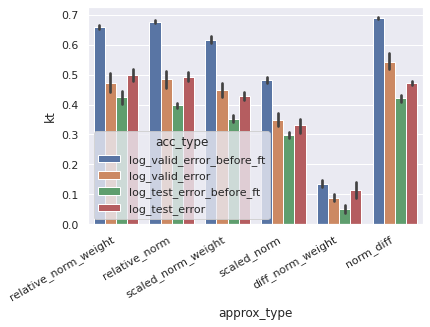

In [34]:
# sns.set_theme(style="whitegrid")

ax = sns.barplot(
    x='approx_type',
    y='kt',
    hue='acc_type',
    data=df_bar,
    # ci="sd", palette="dark", alpha=.6, height=6,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')

# g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
# g.legend.set_title("")

fig = ax.get_figure()
# fig.savefig("../../plots/cifar10/rn18/bar_approx_perform")


In [35]:
# df_kt_mean_std.to_pickle("./tables/kt_rn18_c10_mean_std.zip")

## Kendalls tau per layer

In [36]:
df['layers'].unique()

[63, 60, 28, 38, 41, 44, 15, 19]
Categories (8, int64): [63, 60, 28, 38, 41, 44, 15, 19]

In [37]:
# from scipy.stats import kendalltau
dfs = split_into_run(df, 5)
# n = 0
# layer = 63
model = 'ResNet-18'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm'] # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
layers = [15,19,28,38,41,44,60,63]
N = 5

df_layers_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error','model','dataset'])
df_means = pd.DataFrame(columns=approxs, index=performs)
df_mean_layers = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(layers),N))

for p, perform in enumerate(performs):
    print(perform)
    for a, approx in enumerate(approxs):
        print(approx)
        arr = np.zeros((len(layers),N))
        for n in range(N):
            cs = np.zeros(len(layers))
            df_n = dfs[n]
            c_all, _ = kendalltau_a(df_n[perform],df_n[approx])
            for l, layer in enumerate(layers):
                df_n_l = df_n.loc[df_n.layers == layer]
                # print(df_n_l)
                c, _ = kendalltau_a(df_n_l[perform],df_n_l[approx])
                print(f"Layer: {layer}, run: {n}, Kendall's tau {c}")
                df_layers_ = df_layers_.append({
                    'layer':layer,
                    'run':n,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'kt_diff':c-c_all,
                    'model': model,
                    'dataset': dataset,
                }, ignore_index=True)
                array[p, a, l, n] = c
                arr[l,n] = c 
                cs[l] = c
            df_mean_layers = df_mean_layers.append({
                'run':n,
                'performance_metric':perform,
                'approximation_error':approx,
                'kt': cs.mean(),
                'kt_mean': cs.mean(),
                'kt_std': cs.std(),
                'model': model,
                'dataset': dataset,
            }, ignore_index=True)
        df_means[approx][perform] = arr.mean()

# df_layers_.to_pickle("./tables/kta_rn18_c10_bar_log_error_layers.zip")
# df_mean_layers.to_pickle("./tables/kta_rn18_c10_bar_log_error_layers_mean.zip")

log_valid_error_before_ft
relative_norm_weight
Layer: 15, run: 0, Kendall's tau 0.8333333333333334
Layer: 19, run: 0, Kendall's tau 0.8461538461538461
Layer: 28, run: 0, Kendall's tau 0.8333333333333334
Layer: 38, run: 0, Kendall's tau 0.7948717948717948
Layer: 41, run: 0, Kendall's tau 0.9230769230769231
Layer: 44, run: 0, Kendall's tau 0.8974358974358975
Layer: 60, run: 0, Kendall's tau 0.0
Layer: 63, run: 0, Kendall's tau 0.0
Layer: 15, run: 1, Kendall's tau 0.8205128205128205
Layer: 19, run: 1, Kendall's tau 0.8974358974358975
Layer: 28, run: 1, Kendall's tau 0.8333333333333334
Layer: 38, run: 1, Kendall's tau 0.7692307692307693
Layer: 41, run: 1, Kendall's tau 0.9102564102564102
Layer: 44, run: 1, Kendall's tau 0.8205128205128205
Layer: 60, run: 1, Kendall's tau 0.0
Layer: 63, run: 1, Kendall's tau 0.0
Layer: 15, run: 2, Kendall's tau 0.8461538461538461
Layer: 19, run: 2, Kendall's tau 0.8974358974358975
Layer: 28, run: 2, Kendall's tau 0.8333333333333334
Layer: 38, run: 2, Kendal

In [38]:
df_layers_.head()

,kt,layer,run,performance_metric,approximation_error,model,dataset,kt_diff
0,0.833333,15,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.181136
1,0.846154,19,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.193956
2,0.833333,28,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.181136
3,0.794872,38,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.142674
4,0.923077,41,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.270879


In [39]:
# from scipy.stats import kendalltau
dfs = split_into_run(df, 5)
# n = 0
# layer = 63
model = 'ResNet-18'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm'] # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
factorizations = ['cp','tucker','tt']
N = 5

df_factorizations_ = pd.DataFrame(columns=['kt','factorization', 'run', 'performance_metric', 'approximation_error','model','dataset'])
df_means = pd.DataFrame(columns=approxs, index=performs)
df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(factorizations),N))

for p, perform in enumerate(performs):
    print(perform)
    for a, approx in enumerate(approxs):
        print(approx)
        arr = np.zeros((len(factorizations),N))
        for n in range(N):
            cs = np.zeros(len(factorizations))
            df_n = dfs[n]
            c_all, _ = kendalltau_a(df_n[perform],df_n[approx])
            for l, factorization in enumerate(factorizations):
                df_n_l = df_n.loc[df_n.factorization == factorization]
                # print(df_n_l)
                c, _ = kendalltau_a(df_n_l[perform],df_n_l[approx])
                print(f"factorization: {factorization}, run: {n}, Kendall's tau {c}")
                df_factorizations_ = df_factorizations_.append({
                    'factorization':factorization,
                    'run':n,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'kt_diff':c-c_all,
                    'model': model,
                    'dataset': dataset,
                }, ignore_index=True)
                array[p, a, l, n] = c
                arr[l,n] = c 
                cs[l] = c
            df_mean_factorizations = df_mean_factorizations.append({
                'run':n,
                'performance_metric':perform,
                'approximation_error':approx,
                'kt': cs.mean(),
                'kt_mean': cs.mean(),
                'kt_std': cs.std(),
                'model': model,
                'dataset': dataset,
            }, ignore_index=True)
        df_means[approx][perform] = arr.mean()

# df_factorizations_.to_pickle("./tables/kta_rn18_c10_bar_log_error_factorizations.zip")
# df_mean_factorizations.to_pickle("./tables/kta_rn18_c10_bar_log_error_factorizations_mean.zip")

log_valid_error_before_ft
relative_norm_weight
factorization: cp, run: 0, Kendall's tau 0.6363636363636364
factorization: tucker, run: 0, Kendall's tau 0.6310483870967742
factorization: tt, run: 0, Kendall's tau 0.691025641025641
factorization: cp, run: 1, Kendall's tau 0.592741935483871
factorization: tucker, run: 1, Kendall's tau 0.6310483870967742
factorization: tt, run: 1, Kendall's tau 0.691025641025641
factorization: cp, run: 2, Kendall's tau 0.5786290322580645
factorization: tucker, run: 2, Kendall's tau 0.6310483870967742
factorization: tt, run: 2, Kendall's tau 0.691025641025641
factorization: cp, run: 3, Kendall's tau 0.6673387096774194
factorization: tucker, run: 3, Kendall's tau 0.6310483870967742
factorization: tt, run: 3, Kendall's tau 0.691025641025641
factorization: cp, run: 4, Kendall's tau 0.6471774193548387
factorization: tucker, run: 4, Kendall's tau 0.6310483870967742
factorization: tt, run: 4, Kendall's tau 0.691025641025641
relative_norm
factorization: cp, run: 0

In [40]:
df_factorizations_.head()

,kt,factorization,run,performance_metric,approximation_error,model,dataset,kt_diff
0,0.636364,cp,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,-0.021695
1,0.631048,tucker,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,-0.027010
2,0.691026,tt,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.032967
3,0.592742,cp,1,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,-0.055503
4,0.631048,tucker,1,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,-0.017197


In [41]:
std_over_layers_runs = array.std(axis=(-1,-2))
std_over_layers_runs

array([[0.03564459, 0.04804944],
       [0.08119854, 0.07091179],
       [0.15237332, 0.15646064],
       [0.12159124, 0.13204127]])

In [42]:
mean_over_runs_std_over_layers = array.mean(axis=-1).std(axis=-1)
print(mean_over_runs_std_over_layers) 


[[0.02995015 0.04363051]
 [0.06790135 0.05985436]
 [0.14597963 0.15265984]
 [0.11471679 0.1234703 ]]


In [43]:
mean_over_layers_std_over_runs = array.mean(axis=-2).std(axis=-1)
print(mean_over_layers_std_over_runs) 

[[0.01115833 0.01162077]
 [0.01689503 0.02165623]
 [0.02521624 0.01978979]
 [0.01997443 0.01356715]]


In [44]:
array.mean(axis=(-1,-2))

array([[0.64884139, 0.65937602],
       [0.4670504 , 0.46954571],
       [0.38014262, 0.36104908],
       [0.48231878, 0.470704  ]])

In [45]:
array.mean(axis=-1).mean(axis=-1)

array([[0.64884139, 0.65937602],
       [0.4670504 , 0.46954571],
       [0.38014262, 0.36104908],
       [0.48231878, 0.470704  ]])

In [46]:
perform = 'valid_error_before_ft'
approx = 'relative_norm_weight' # ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

In [47]:
df_n_l[perform]

365    0.1686
615    0.1116
389    0.0854
144    0.0802
498    0.0790
570    0.1560
368    0.1004
462    0.0864
410    0.0818
551    0.0804
467    0.4348
616    0.1300
376    0.0890
445    0.0838
417    0.0838
356    0.2846
602    0.0880
279    0.0834
352    0.0810
35     0.0796
174    0.0980
330    0.0980
104    0.0968
469    0.0828
463    0.0816
343    0.1344
477    0.0856
246    0.0804
386    0.0790
574    0.0788
208    0.0784
321    0.0784
516    0.0784
39     0.0784
565    0.0784
296    0.0784
564    0.0784
114    0.0784
252    0.0784
87     0.0784
Name: valid_error_before_ft, dtype: float64

In [48]:
df_n_l[approx]

365    0.904281
615    0.785133
389    0.597638
144    0.391674
498    0.313310
570    0.878795
368    0.697391
462    0.538278
410    0.380051
551    0.296318
467    0.956844
616    0.820082
376    0.643662
445    0.459486
417    0.373532
356    0.961171
602    0.757140
279    0.570406
352    0.404784
35     0.328759
174    0.977503
330    0.977503
104    0.959029
469    0.709444
463    0.601941
343    0.951841
477    0.734045
246    0.553463
386    0.390840
574    0.316696
208    0.575679
321    0.334154
516    0.256149
39     0.187764
565    0.152464
296    0.539368
564    0.313173
114    0.244584
252    0.181188
87     0.147862
Name: relative_norm_weight, dtype: float64

In [49]:
array

array([[[[0.63636364, 0.59274194, 0.57862903, 0.66733871, 0.64717742],
         [0.63104839, 0.63104839, 0.63104839, 0.63104839, 0.63104839],
         [0.69102564, 0.69102564, 0.69102564, 0.69102564, 0.69102564]],

        [[0.67424242, 0.65322581, 0.58266129, 0.66733871, 0.67540323],
         [0.6108871 , 0.6108871 , 0.6108871 , 0.6108871 , 0.6108871 ],
         [0.71666667, 0.71666667, 0.71666667, 0.71666667, 0.71666667]]],


       [[[0.38257576, 0.32258065, 0.34677419, 0.49798387, 0.35282258],
         [0.46370968, 0.54637097, 0.47379032, 0.41935484, 0.46774194],
         [0.56794872, 0.55897436, 0.54358974, 0.55512821, 0.50641026]],

        [[0.4469697 , 0.39112903, 0.35483871, 0.47782258, 0.39314516],
         [0.41935484, 0.52620968, 0.42943548, 0.40322581, 0.43951613],
         [0.55128205, 0.58076923, 0.53974359, 0.57435897, 0.51538462]]],


       [[[0.23863636, 0.0625    , 0.18145161, 0.28427419, 0.22782258],
         [0.38508065, 0.38508065, 0.38508065, 0.38508065, 0.38508

In [50]:
array_masked = np.ma.array(array, mask=np.isnan(array))

In [51]:
array_masked_mean = array_masked.mean(axis=(2,3))

In [52]:
pd.DataFrame(data=array_masked_mean, columns=approxs, index=performs)

,relative_norm_weight,relative_norm
log_valid_error_before_ft,0.648841,0.659376
log_valid_error,0.467050,0.469546
log_test_error_before_ft,0.380143,0.361049
log_test_error,0.482319,0.470704


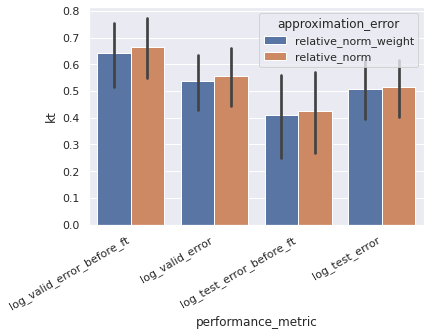

In [53]:
ax = sns.barplot(
    x='performance_metric',
    y='kt',
    hue='approximation_error',
    data=df_layers_,
    # ci="sd", palette="dark", alpha=.6, height=6,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')
fig = ax.get_figure()

In [54]:
df_layers_.groupby(['approximation_error','performance_metric',]).mean()

kt   kt_diff
approximation_error  performance_metric                           
relative_norm        log_test_error             0.513416  0.021779
                     log_test_error_before_ft   0.424542  0.026523
                     log_valid_error            0.554762  0.067974
                     log_valid_error_before_ft  0.664103 -0.011711
relative_norm_weight log_test_error             0.508608  0.009619
                     log_test_error_before_ft   0.409890 -0.014896
                     log_valid_error            0.536310  0.063599
                     log_valid_error_before_ft  0.642949 -0.016169

In [55]:
from tddl.post_processing.kendalls_tau import split_into_layers, mean_over_runs, df_for_bar

metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

dfs_layers = split_into_layers(df, 'nr')

df_kts_layers = calculate_kendalls_tau_per_run(dfs_layers, errors=errors, metrics=metrics)
# df_kts_layers_bar = df_for_bar(
#     df_kts_layers,     
#     dataset='CIFAR-10', 
#     model='ResNet-18', 
#     errors=errors, 
#     metrics=metrics,
# )
# df_kts_layers_bar.to_pickle("./tables/kt_rn18_c10_bar_error_layers.zip")

df_kt_layers_mean = pd.DataFrame(mean_over_runs(df_kts), index=metrics, columns=errors)

# dfs = split_into_run(df, 5)
# df_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
# df_kt_mean_std = mean_std_over_runs(df_kts, errors=errors, metrics=metrics)
# df_kt_mean_std

ValueError: Shape of passed values is (4, 6), indices imply (3, 6)

In [56]:
dfs_layers[0]
dfs_0 = split_into_run(dfs_layers[0], 5)
dfl_kts_0 = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
df_kt_layers_means_0 = pd.DataFrame(mean_over_runs(dfl_kts_0), index=metrics, columns=errors)
df_kt_layer_mean_0 = pd.DataFrame(mean_over_runs([df_kt_layers_means_0]), index=metrics, columns=errors)

In [57]:
df_kt_layers_means_0

,relative_norm_weight,relative_norm,scaled_norm_weight,scaled_norm,diff_norm_weight,norm_diff
log_valid_error_before_ft,0.658871,0.675503,0.617185,0.481002,0.133881,0.687368
log_valid_error,0.471518,0.481163,0.446083,0.345454,0.088326,0.541992
log_test_error,0.497088,0.491641,0.427092,0.331239,0.118791,0.471077


In [58]:
dfs[0]

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,test_error,valid_error_before_ft,valid_error,log_test_error_before_ft,log_test_error,log_valid_error_before_ft,log_valid_error,fact_rank,fact_layers,layers_fact
430,conv2,15,0.714103,0.000709,26.129057,15,cp,0.10,0.9172,0.9120,...,0.0867,0.0880,0.0828,-2.369794,-2.445301,-2.430418,-2.491327,cp-0.1,cp-15,15-cp
539,conv2,15,0.497708,0.000494,18.211176,15,cp,0.25,0.9198,0.9186,...,0.0865,0.0814,0.0802,-2.445301,-2.447611,-2.508380,-2.523232,cp-0.25,cp-15,15-cp
17,conv2,15,0.304725,0.000302,11.149886,15,cp,0.50,0.9206,0.9198,...,0.0860,0.0802,0.0794,-2.449926,-2.453408,-2.523232,-2.533257,cp-0.5,cp-15,15-cp
353,conv2,15,0.121650,0.000121,4.451193,15,cp,0.90,0.9202,0.9218,...,0.0858,0.0782,0.0798,-2.453408,-2.455736,-2.548486,-2.528232,cp-0.9,cp-15,15-cp
358,conv2,15,0.904281,0.000898,33.087673,15,tt,0.16,0.9078,0.8314,...,0.0962,0.1686,0.0922,-1.794563,-2.341326,-1.780226,-2.383795,tt-0.16,tt-15,15-tt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,conv2,63,0.147862,0.000011,25.976234,63,tt,80.00,0.9212,0.9216,...,0.0854,0.0784,0.0788,-2.449926,-2.460409,-2.545931,-2.540842,tt-80.0,tt-63,63-tt
264,conv2,63,0.313901,0.000023,55.145676,63,tucker,0.10,0.9214,0.9216,...,0.0863,0.0784,0.0786,-2.451085,-2.449926,-2.545931,-2.543384,tucker-0.1,tucker-63,63-tucker
363,conv2,63,0.258644,0.000019,45.438248,63,tucker,0.25,0.9214,0.9216,...,0.0863,0.0784,0.0786,-2.449926,-2.449926,-2.545931,-2.543384,tucker-0.25,tucker-63,63-tucker
215,conv2,63,0.198279,0.000015,34.833344,63,tucker,0.50,0.9212,0.9216,...,0.0861,0.0784,0.0788,-2.449926,-2.452246,-2.545931,-2.540842,tucker-0.5,tucker-63,63-tucker


In [60]:
print(df_kts[0])

[[0.6644689  0.6875458  0.63443226 0.48168498 0.13589744 0.6908425 ]
 [0.42600733 0.43644688 0.41062272 0.31666666 0.07326008 0.50860804]
 [0.38772893 0.38516483 0.3514652  0.28003663 0.03058608 0.40238094]
 [0.4668498  0.4860806  0.4474359  0.2893773  0.07051282 0.46300367]]


In [61]:
dfs_layers[0].head()

,name,nr,relative_norm_weight,scaled_norm_weight,diff_norm_weight,layers,factorization,rank,valid_acc,valid_acc_before_ft,...,test_error,valid_error_before_ft,valid_error,log_test_error_before_ft,log_test_error,log_valid_error_before_ft,log_valid_error,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,0.000023,54.784103,63,cp,0.10,0.9210,0.9216,...,0.0857,0.0784,0.0790,-2.451085,-2.456902,-2.545931,-2.538307,cp-0.1,cp-63,63-cp
6,conv2,63,0.198279,0.000015,34.833344,63,tucker,0.50,0.9210,0.9216,...,0.0855,0.0784,0.0790,-2.449926,-2.459239,-2.545931,-2.538307,tucker-0.5,tucker-63,63-tucker
16,conv2,63,0.539368,0.000040,94.755577,63,tt,0.19,0.9208,0.9216,...,0.0850,0.0784,0.0792,-2.449926,-2.465104,-2.545931,-2.535779,tt-0.19,tt-63,63-tt
48,conv2,63,0.244584,0.000018,42.968273,63,tt,17.90,0.9216,0.9216,...,0.0850,0.0784,0.0784,-2.449926,-2.465104,-2.545931,-2.545931,tt-17.9,tt-63,63-tt
51,conv2,63,0.181188,0.000013,31.830917,63,tt,50.00,0.9214,0.9216,...,0.0854,0.0784,0.0786,-2.449926,-2.460409,-2.545931,-2.543384,tt-50.0,tt-63,63-tt


In [62]:
from tddl.post_processing.kendalls_tau import split_into_layers, mean_over_runs, df_for_bar

metrics=['log_valid_error_before_ft','log_valid_error','log_test_error']
errors=['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']

dfs_layers = split_into_layers(df, 'nr')

df_kt_layers_means = []
for dfl in dfs_layers:
    dfs = split_into_run(dfl, 5)
    print(len(dfs))
    dfl_kts = calculate_kendalls_tau_per_run(dfs, errors=errors, metrics=metrics)
    df_kt_layers_means.append(
        pd.DataFrame(mean_over_runs(dfl_kts), index=metrics, columns=errors)
    )
df_kt_layer_mean = pd.DataFrame(mean_over_runs(df_kt_layers_means), index=metrics, columns=errors)

df_kt_layer_mean

neat_table_indices = {
    'log_valid_error_before_ft': "V B",
    'log_valid_error': "V A",
    'log_test_error': "T A",
}
neat_table_columns = {				
    "relative_norm_weight": "RW",
    "scaled_norm_weight": "SW",
    "diff_norm_weight": "DW",
    "relative_norm": "RF",
    "scaled_norm": "SF",
    "norm_diff": "DF",
    "layers": "L"
}

df_kt_layers_mean.rename(index=neat_table_indices ,columns=neat_table_columns, inplace=True)
ktl = df_kt_layers_mean.round(decimals=2)

print(ktl.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10. Kendall's tau is calculated per layer per run, then averaged over all layers and runs.",
    label='kt_rn18_c10_errors_performances_layers',
))


5
5
5
5
5
5
5
5


NameError: name 'df_kt_layers_mean' is not defined

In [63]:
neat_table_indices = {
    'log_test_error_before_ft': "V B",
    'log_valid_error_before_ft': "V B",
    'log_valid_error': "V A",
    'log_test_error': "T A",
}
neat_table_columns = {				
    "relative_norm_weight": "RW",
    "scaled_norm_weight": "SW",
    "diff_norm_weight": "DW",
    "relative_norm": "RF",
    "scaled_norm": "SF",
    "norm_diff": "DF",
    "layers": "L"
}
df_kt_layers_mean.rename(index=neat_table_indices ,columns=neat_table_columns, inplace=True)
ktl = df_kt_layers_mean.round(decimals=2)

NameError: name 'df_kt_layers_mean' is not defined

In [64]:
print(ktl.to_latex(
    position='htbp', 
#     caption="
    label='kt_rn18_c10_errors_performances_layers'
))
# print(df_kt_factorizations.to_latex(
#     position='htbp', 
#     caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
#     label='kt_rn18_c10_errors_performances_factorization',
# ))

NameError: name 'ktl' is not defined

In [ ]:
df_kts_layers_bar = df_for_bar(
    df_kts_layers,     
    dataset='CIFAR-10', 
    model='ResNet-18', 
    errors=errors, 
    metrics=metrics,
)
# df_kts_layers_bar.to_pickle("./tables/kt_rn18_c10_bar_error_layers.zip")


TypeError: list indices must be integers or slices, not tuple

## Kendalls tau varying layers

In [66]:
df['actual_rank'] = df['rank']
rank_conf = {
    10: [
        0.16,
        0.31,
        0.18,
        0.19,
        0.45,
        0.19,
        0.19,
        0.19,
    ],
    25: [
        0.61,
        1.43,
        1.22,
        2.39,
        1.21,
        2.39,
        4.78,
        4.78,
    ],
    50: [
        2.30,
        3.52,
        4.57,
        8.98,
        2.40,
        8.98,
        17.90,
        17.90,
    ],
    75: [
        6.60,
        7.8,
        12.97,
        25.6,
        28.0,
        25.6,
        50.0,
        50.0,
    ],
    90: [
        10.3,
        12.5,
        20.0,
        40.0,
        45.0,
        40.0,
        80.0,
        80.0,
    ],
}
for k,v in rank_conf.items():
    print(k,v)
    df.loc[df['rank'].isin(v), 'actual_rank'] = k/100

10 [0.16, 0.31, 0.18, 0.19, 0.45, 0.19, 0.19, 0.19]
25 [0.61, 1.43, 1.22, 2.39, 1.21, 2.39, 4.78, 4.78]
50 [2.3, 3.52, 4.57, 8.98, 2.4, 8.98, 17.9, 17.9]
75 [6.6, 7.8, 12.97, 25.6, 28.0, 25.6, 50.0, 50.0]
90 [10.3, 12.5, 20.0, 40.0, 45.0, 40.0, 80.0, 80.0]


In [67]:
df[['rank','actual_rank']]

,rank,actual_rank
0,0.10,0.10
1,0.10,0.10
2,0.25,0.25
3,80.00,0.90
4,0.10,0.10
...,...,...
615,0.61,0.25
616,1.22,0.25
617,0.10,0.10
618,0.10,0.10


In [68]:
dfs[0].columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'test_acc_before_ft', 'n_param_fact', 'test_acc',
       'lr', 'optimizer', 'norm_diff', 'norm_b', 'n_b', 'relative_norm',
       'scaled_norm', 'test_error_before_ft', 'test_error',
       'valid_error_before_ft', 'valid_error', 'log_test_error_before_ft',
       'log_test_error', 'log_valid_error_before_ft', 'log_valid_error',
       'fact_rank', 'fact_layers', 'layers_fact'],
      dtype='object')

In [69]:
dfs = split_into_run(df, 5)

model = 'ResNet-18'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_layers_ = pd.DataFrame(columns=['kt','factorization', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
factorizations = df.factorization.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                for f in factorizations:
                    df_i_r_f = df_i_r[df_i_r.factorization == f]
                    # select rows where factorization == d
                    # kt over df_layers
                    c, _ = kendalltau_a(df_i_r_f[perform],df_i_r_f[approx])
                    df_layers_ = df_layers_.append({
                        'factorization':f,
                        'performance_metric':perform,
                        'approximation_error':approx,
                        'kt': c,
                        'model': model,
                        'dataset': dataset,
                        'rank': r,
                        'run': i,
                    }, ignore_index=True)

df_layers_.to_pickle("./tables/kta_rn18_c10_bar_log_error_across_layers_incl75-9.zip")

In [70]:
df_layers_

,kt,factorization,run,performance_metric,approximation_error,model,dataset,rank
0,0.607143,cp,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.10
1,0.678571,tucker,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.10
2,0.392857,tt,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.10
3,0.500000,cp,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.25
4,0.464286,tucker,0,log_valid_error_before_ft,relative_norm_weight,ResNet-18,CIFAR-10,0.25
...,...,...,...,...,...,...,...,...
1795,0.285714,tucker,4,log_test_error,norm_diff,ResNet-18,CIFAR-10,0.50
1796,0.535714,tt,4,log_test_error,norm_diff,ResNet-18,CIFAR-10,0.50
1797,NaN,cp,4,log_test_error,norm_diff,ResNet-18,CIFAR-10,0.75
1798,NaN,tucker,4,log_test_error,norm_diff,ResNet-18,CIFAR-10,0.75


In [71]:
tmp = df_layers_.groupby(['performance_metric','approximation_error','model','dataset','run'])['kt'].mean().reset_index()
tmp2 = tmp.groupby(['performance_metric','approximation_error','model','dataset'])['kt'].mean().reset_index()

In [72]:
tmp[
    (tmp['Performance measure'] == 'Test error before fine-tuning')
    & (tmp['approximation_error'] == 'Relative Weights')
    & (tmp['model & dataset'] == 'ResNet-18 & CIFAR-10')
]

KeyError: 'Performance measure'

In [73]:
tmp['model & dataset'] = tmp['model'] + ' & ' + tmp['dataset']

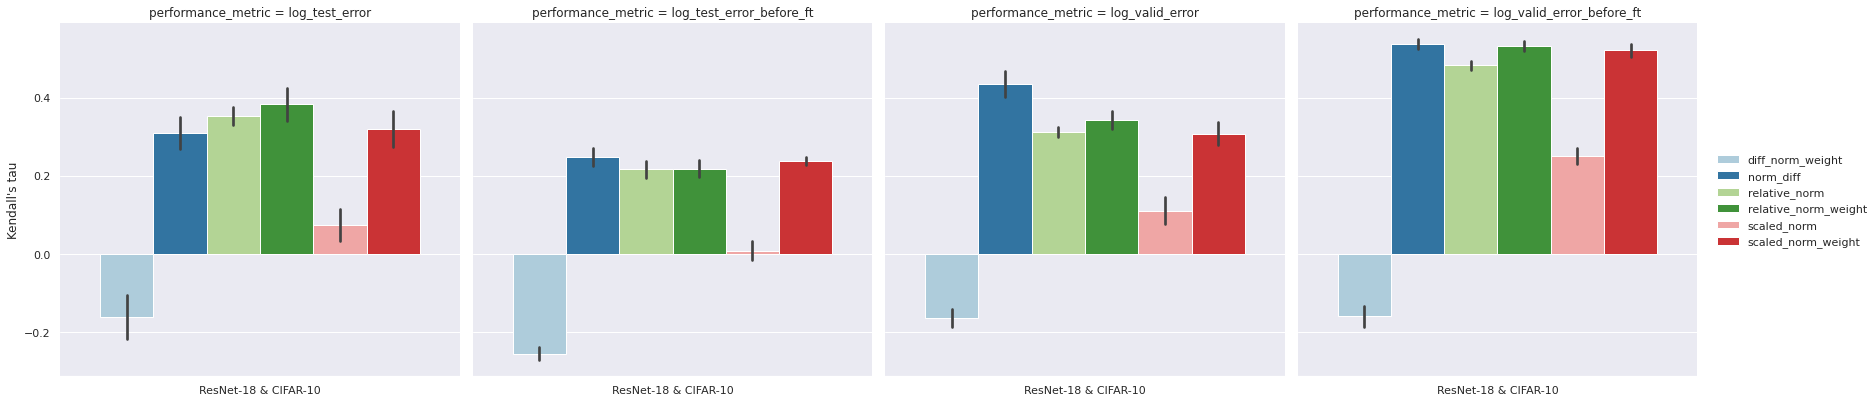

In [74]:
titles = [
    'Performance measure'
]

hue_order = ['Relative Weights','Relative Features','Scaled Weights','Scaled Features','Absolute Weights','Absolute Features']
col_order = ['ResNet-18 & CIFAR-10','GaripovNet & CIFAR-10','GaripovNet & F-MNIST']

g = sns.catplot(
    data=tmp,
    kind="bar",
    x="model & dataset",
    y="kt",
    hue="approximation_error",
    ci="sd", 
    palette=sns.color_palette("Paired"), # "dark", 
    # alpha=.6, 
    height=6,
    col= 'performance_metric',# "model & dataset",
    # row="model", 
    # hue_order=hue_order,
    # order=col_order,
)
g.despine(left=True)
g.set_axis_labels("", "Kendall's tau")
# g.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
g.legend.set_title("")
# for i in range(1):
#     for j in range(2):
#         gax = g.axes[i][j]
#         # xlabel = gax.get_xlabel()
#         # ylabel = gax.get_ylabel()
#         # print(xlabel)
#         # if xlabel in replacements.keys():
#         #     print(xlabel)
#         #     g.axes[i][j].set_xlabel(replacements[xlabel])

#         gax.set_xticklabels(gax.get_xticklabels(),rotation = 15, fontdict={'horizontalalignment':'right'})# 'center', 'left', 'right')
        # gax.set_title(performance_measures[j])

In [75]:
df.layers.unique() # 'nr' 'layers'

[63, 60, 28, 38, 41, 44, 15, 19]
Categories (8, int64): [63, 60, 28, 38, 41, 44, 15, 19]

In [76]:
dfs = split_into_run(df, 5)

model = 'ResNet-18'
dataset = 'CIFAR-10'
performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_facts_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

# array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
layers = df.layers.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                for l in layers:
                    df_i_r_l = df_i_r[df_i_r.layers == l]
                    # select rows where factorization == d
                    # kt over df_layers
                    c, _ = kendalltau_a(df_i_r_l[perform],df_i_r_l[approx])
                    df_facts_ = df_facts_.append({
                        'layer':l,
                        'performance_metric':perform,
                        'approximation_error':approx,
                        'kt': c,
                        'model': model,
                        'dataset': dataset,
                        'rank': r,
                        'run': i,
                    }, ignore_index=True)

df_facts_.to_pickle("./tables/kta_rn18_c10_bar_log_error_across_facts_incl75-9.zip")

In [84]:
dfs = split_into_run(df, 5)

model = 'ResNet-18'
dataset = 'CIFAR-10'
performs = ['log_test_error_before_ft','log_test_error'] # 'log_valid_error_before_ft','log_valid_error',
# performs = ['log_valid_error_before_ft','log_valid_error','log_test_error_before_ft','log_test_error']
approxs = ['relative_norm_weight','relative_norm','scaled_norm_weight','scaled_norm','diff_norm_weight','norm_diff']
N = 5

df_layer_fact_ = pd.DataFrame(columns=['kt','layer', 'run', 'performance_metric', 'approximation_error','model','dataset'])
# df_means = pd.DataFrame(columns=approxs, index=performs)
# df_mean_factorizations = pd.DataFrame(columns=['kt','run', 'performance_metric', 'approximation_error','model','dataset'])

# array = np.zeros((len(performs),len(approxs),len(factorizations),N))

ranks = df.actual_rank.unique()
# layers = df.layers.unique()
for p, perform in enumerate(performs):
    for a, approx in enumerate(approxs):
        for i in range(len(dfs)):
            # select i-th runs
            df_i = dfs[i]
            for r in ranks:
                df_i_r = df_i[df_i.actual_rank == r]
                # select rows where rank == r
                # for l in layers:
                    # df_i_r_l = df_i_r[df_i_r.layers == l]
                    # select rows where factorization == d
                    # kt over df_layers
                c, _ = kendalltau_a(df_i_r[perform],df_i_r[approx])
                print(f'{approx=}', f'{r=}', f'{i=}', f'{c=}')
                df_layer_fact_ = df_layer_fact_.append({
                    # 'layer':l,
                    'performance_metric':perform,
                    'approximation_error':approx,
                    'kt': c,
                    'model': model,
                    'dataset': dataset,
                    'rank': r,
                    'run': i,
                }, ignore_index=True)

df_layer_fact_.to_pickle("./tables/kta_rn18_c10_bar_log_error_across_layer_facts_incl75-9.zip")

approx='relative_norm_weight' r=0.1 i=0 c=0.6630434782608695
approx='relative_norm_weight' r=0.25 i=0 c=0.45652173913043476
approx='relative_norm_weight' r=0.9 i=0 c=-0.03666666666666667
approx='relative_norm_weight' r=0.5 i=0 c=0.26811594202898553
approx='relative_norm_weight' r=0.75 i=0 c=0.25
approx='relative_norm_weight' r=0.1 i=1 c=0.6304347826086957
approx='relative_norm_weight' r=0.25 i=1 c=0.42391304347826086
approx='relative_norm_weight' r=0.9 i=1 c=0.0
approx='relative_norm_weight' r=0.5 i=1 c=0.2463768115942029
approx='relative_norm_weight' r=0.75 i=1 c=0.25
approx='relative_norm_weight' r=0.1 i=2 c=0.6485507246376812
approx='relative_norm_weight' r=0.25 i=2 c=0.4384057971014493
approx='relative_norm_weight' r=0.9 i=2 c=-0.043478260869565216
approx='relative_norm_weight' r=0.5 i=2 c=0.2644927536231884
approx='relative_norm_weight' r=0.75 i=2 c=0.25
approx='relative_norm_weight' r=0.1 i=3 c=0.6557971014492754
approx='relative_norm_weight' r=0.25 i=3 c=0.48188405797101447
appr

# Pearson Correlation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [ ]:
from scipy.stats import pearsonr

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc_before_ft','test_acc']

df_pr = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = pearsonr(df[error], df[metric])
        df_pr[error][metric] = corr

KeyError: 'error'

In [ ]:
df_pr.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)

print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Pearson's rho from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='pr_rn18_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Pearson's rho from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and absolute norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{pr_rn18_c10_errors_performances}
\begin{tabular}{llllllll}
\toprule
{} & relative\_norm\_weight & Relative-features & scaled\_norm\_weight & Scaled-features & diff\_norm\_weight & Absolute-features & layers \\
\midrule
log\_valid\_error\_before\_ft &                 0.68 &              0.68 &               0.55 &            0.42 &            0.07* &              0.64 &  -0.45 \\
log\_valid\_error           &                 0.56 &              0.55 &               0.46 &            0.35 &     

In [ ]:
df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

KeyError: 'error'

In [ ]:
df_pr_layers

,relative_norm_weight-log_valid_error_before_ft,relative_norm_weight-log_valid_error,relative_norm_weight-log_test_error_before_ft,relative_norm_weight-log_test_error,relative_norm-log_valid_error_before_ft,relative_norm-log_valid_error,relative_norm-log_test_error_before_ft,relative_norm-log_test_error,scaled_norm_weight-log_valid_error_before_ft,scaled_norm_weight-log_valid_error,...,diff_norm_weight-log_test_error_before_ft,diff_norm_weight-log_test_error,norm_diff-log_valid_error_before_ft,norm_diff-log_valid_error,norm_diff-log_test_error_before_ft,norm_diff-log_test_error,layers-log_valid_error_before_ft,layers-log_valid_error,layers-log_test_error_before_ft,layers-log_test_error
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


KeyError: 'error'

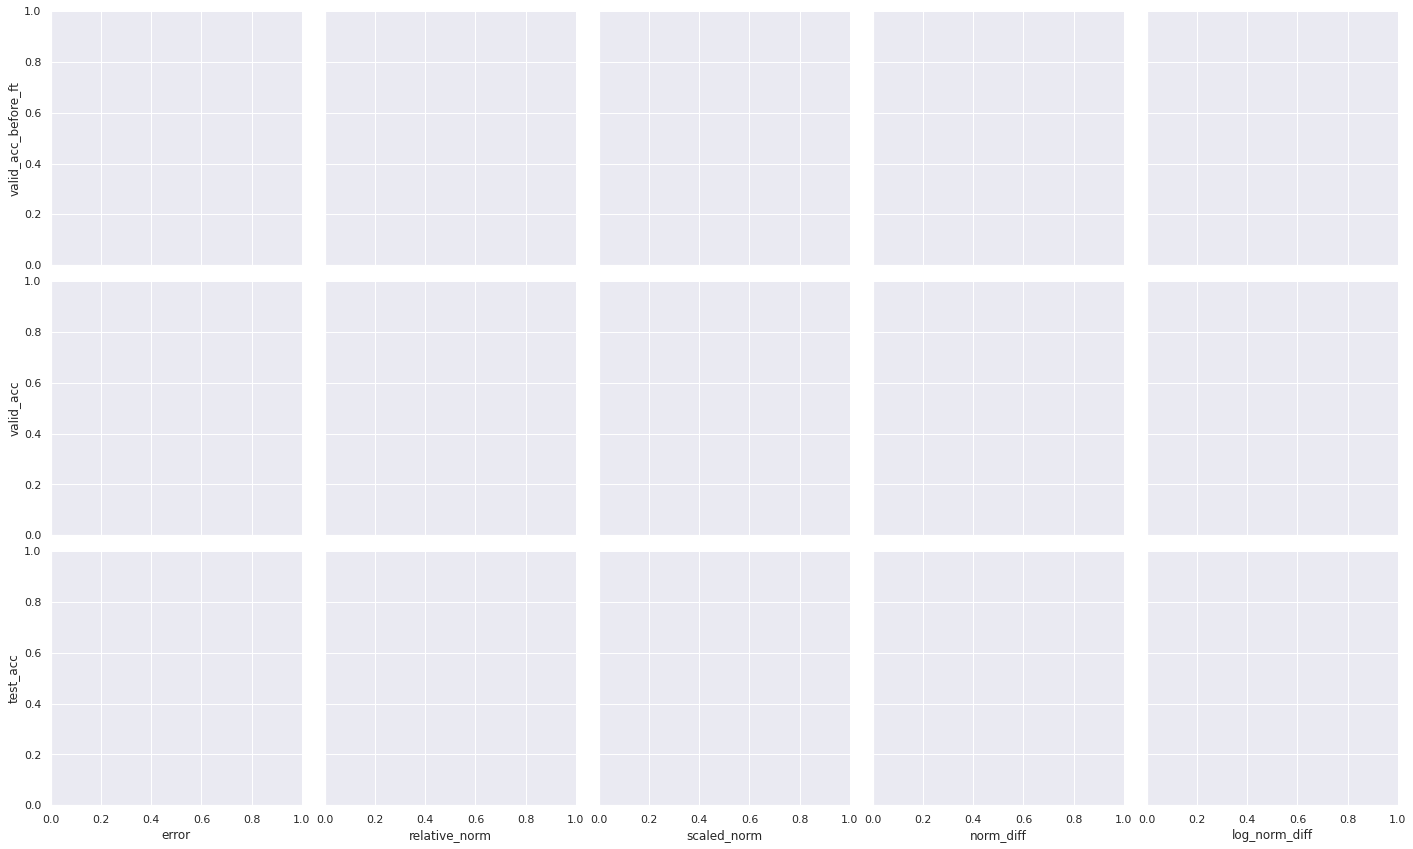

In [ ]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm","norm_diff" ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_errors_performances_layers")

In [51]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'relative_norm_weight': 'Relative Weights',
    'scaled_norm_weight': 'Scaled Weights',
    'diff_norm_weight': 'Absolute Weights',
    'relative_norm': 'Relative Features',
    'scaled_norm': 'Scaled Features',
    'norm_diff': 'Absolute Features',
    'log_valid_error_before_ft': 'Log Validation error before fine-tuning',
    'log_valid_error': 'Log Validation error after fine-tuning',
    'log_test_error': 'Log Test error after fine-tuning'
    # 'log_norm_diff': 'Log norm of the Absolute between training features',
}

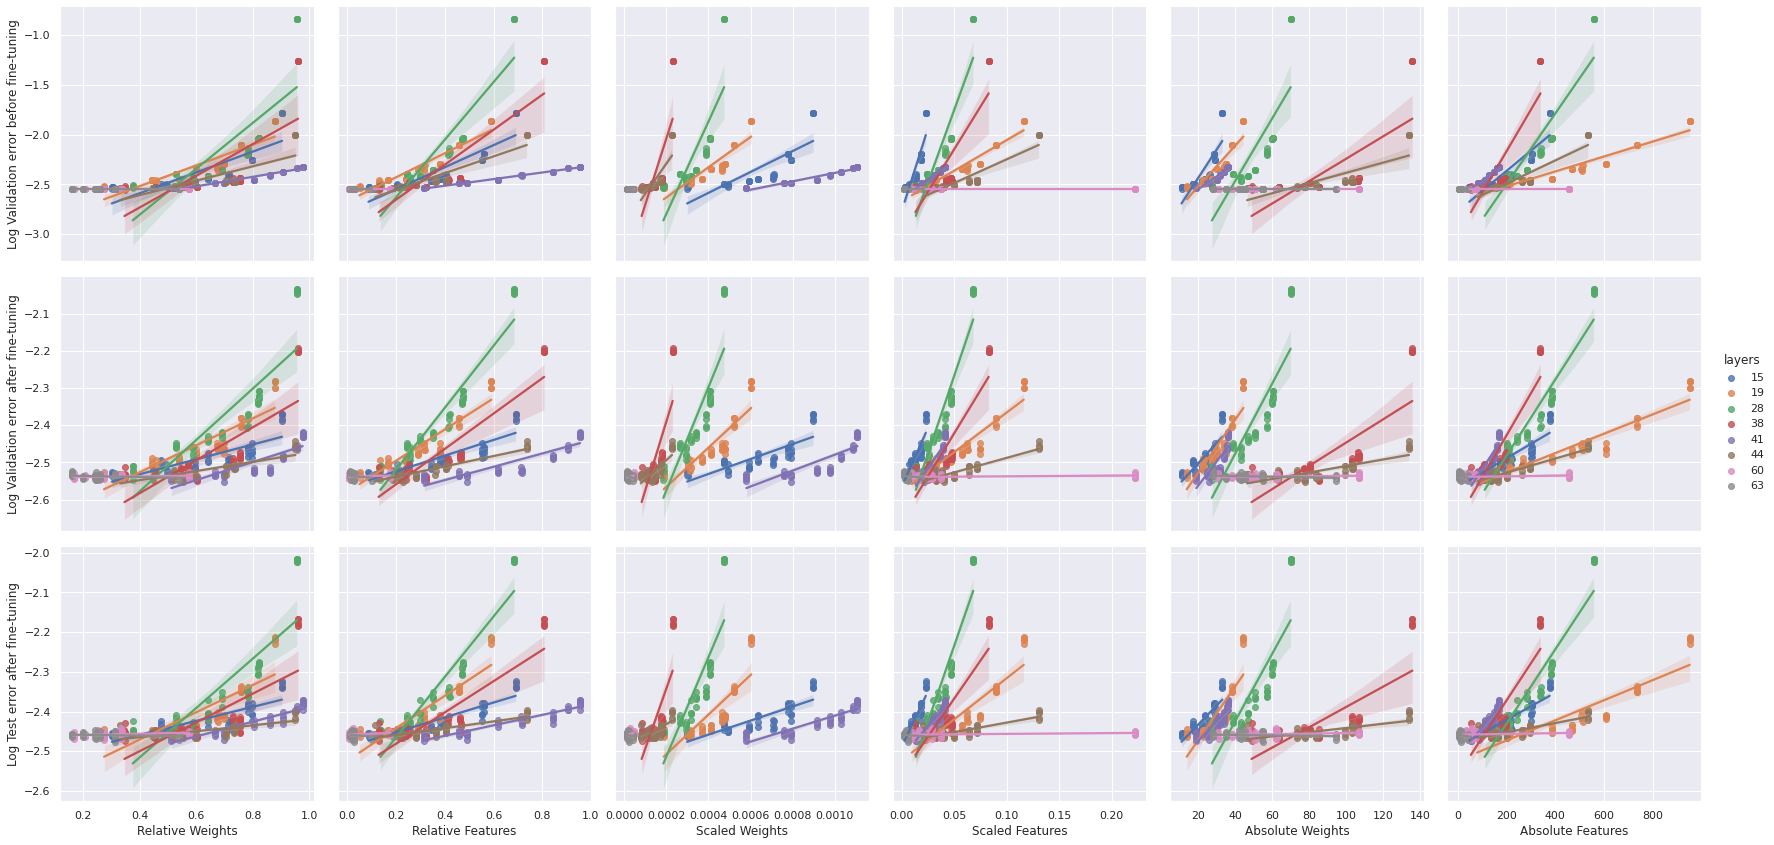

In [52]:
g = sns.PairGrid(
    df,
    y_vars=metrics, # ["valid_error_before_ft", "log_valid_error","log_test_error"], 
    x_vars=errors, # ["relative_norm", "scaled_norm","norm_diff"],# ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
# g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(6):
        gax = g.axes[i][j]
        # gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_errors_performances_layers")

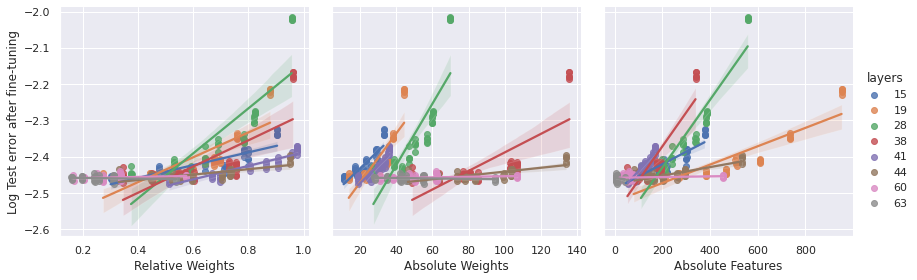

In [53]:
metrics = ['log_test_error']
errors = ["relative_norm_weight", "diff_norm_weight", "norm_diff",]
    # 'relative_norm_weight': 'Relative Weights',
    # 'scaled_norm_weight': 'Scaled Weights',
    # 'diff_norm_weight': 'Absolute Weights',
    # 'relative_norm': 'Relative Features',
    # 'scaled_norm': 'Scaled Features',
    # 'norm_diff': 'Absolute Features',

g = sns.PairGrid(
    df,
    y_vars=metrics, # ["valid_error_before_ft", "log_valid_error","log_test_error"], 
    x_vars=errors, # ["relative_norm", "scaled_norm","norm_diff"],# ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
# g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(1):
    for j in range(3):
        gax = g.axes[i][j]
        # gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_ltd-approx_test-after-ft_layers")

KeyError: 'error'

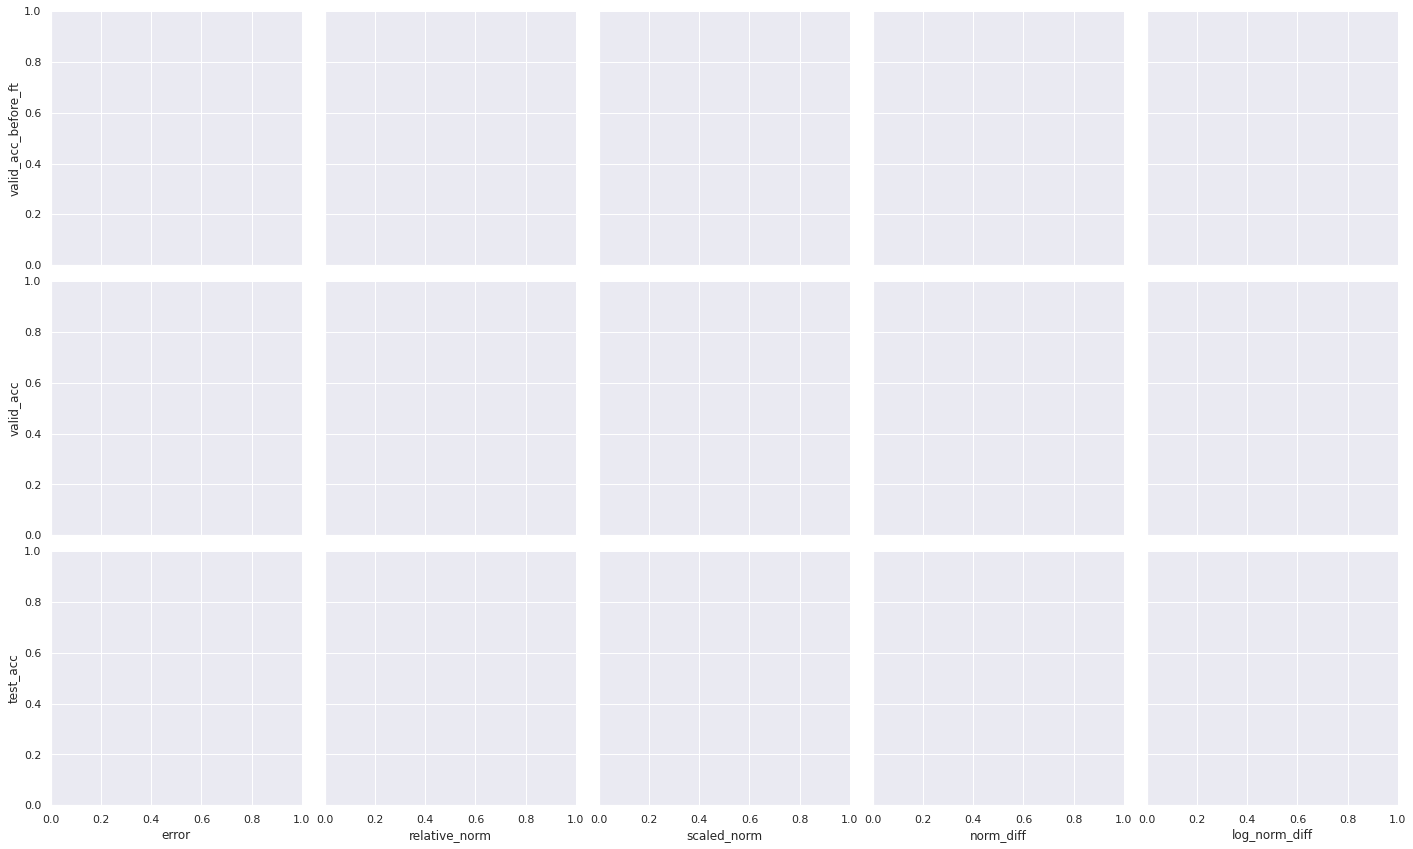

In [ ]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff","log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(lambda x, y, **kwargs: sns.regplot(x=x,y=y,order=2)) # sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

# plt.legend(
#     bbox_to_anchor=(1.05, 1,1,1),
#     loc='upper left', borderaxespad=0.
# )
# g.savefig("../../plots/cifar10/rn18/rn18_c10_poly2_errors_performances_layers")

In [ ]:
from statsmodels.api import OLS

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_ols = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        res = OLS(df[metric], df[error], hasconst=True).fit()
        print(res.summary())
        # df_kt[error][metric] = (corr, p)

KeyError: 'error'

In [178]:



df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [179]:
df_pr_layers

,relative_norm_weight-log_valid_error_before_ft,relative_norm_weight-log_valid_error,relative_norm_weight-log_test_error_before_ft,relative_norm_weight-log_test_error,relative_norm-log_valid_error_before_ft,relative_norm-log_valid_error,relative_norm-log_test_error_before_ft,relative_norm-log_test_error,scaled_norm_weight-log_valid_error_before_ft,scaled_norm_weight-log_valid_error,...,diff_norm_weight-log_test_error_before_ft,diff_norm_weight-log_test_error,norm_diff-log_valid_error_before_ft,norm_diff-log_valid_error,norm_diff-log_test_error_before_ft,norm_diff-log_test_error,layers-log_valid_error_before_ft,layers-log_valid_error,layers-log_test_error_before_ft,layers-log_test_error
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
